In [1]:
# ===================================================================
# ANALISIS SENTIMEN PELANGGAN CAFE C28 GROUP
# Perbandingan 6 Cabang Berdasarkan Ulasan Google Maps
# ===================================================================
# Author: [ADI PRABU JAYANEGARA 5220411346]
# Date: 2025
# ===================================================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Konfigurasi visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300


In [2]:
# ===================================================================
# BAGIAN 1: LOADING & EKSPLORASI DATA
# ===================================================================
print("="*90)
print(" "*20 + "ANALISIS SENTIMEN CAFE C28 GROUP")
print(" "*25 + "Google Maps Reviews Analysis")
print("="*90)
print()

# === CELL 1: Load Data ===
print("📂 CELL 1: LOADING DATA")
print("-"*90)

files = {
    '1009 Palagan': 'data_1009_palagan.csv',
    'C28 Urip Sumoharjo': 'data_c28_urip_sumoharjo.csv',
    'C28 Malioboro': 'data_c28_malioboro.csv',
    'Machia Palagan': 'data_machia_palagan.csv',
    'Machia Seturan': 'data_machia_seturan.csv',
    'Michael Kreme Gelato': 'data_michael_kreme_gelato_palagan.csv'
}

df_list = []
load_summary = []

for name, file in files.items():
    try:
        df = pd.read_csv(file, encoding='utf-8')
        df['cabang'] = name
        df_list.append(df)
        load_summary.append({
            'Cabang': name,
            'Jumlah Reviews': len(df),
            'Status': '✓ Success'
        })
        print(f"✓ Loaded: {name:30s} | Reviews: {len(df):5d}")
    except Exception as e:
        load_summary.append({
            'Cabang': name,
            'Jumlah Reviews': 0,
            'Status': f'✗ Error: {str(e)[:30]}'
        })
        print(f"✗ Error loading {file}")

df_all = pd.concat(df_list, ignore_index=True)

print(f"\n{'='*90}")
print(f"📊 TOTAL DATA LOADED: {len(df_all):,} reviews from {len(files)} branches")
print(f"{'='*90}\n")

                    ANALISIS SENTIMEN CAFE C28 GROUP
                         Google Maps Reviews Analysis

📂 CELL 1: LOADING DATA
------------------------------------------------------------------------------------------
✓ Loaded: 1009 Palagan                   | Reviews:  2110
✓ Loaded: C28 Urip Sumoharjo             | Reviews:  1170
✓ Loaded: C28 Malioboro                  | Reviews:  2110
✓ Loaded: Machia Palagan                 | Reviews:  1600
✓ Loaded: Machia Seturan                 | Reviews:  1250
✓ Loaded: Michael Kreme Gelato           | Reviews:  2060

📊 TOTAL DATA LOADED: 10,300 reviews from 6 branches



In [3]:
# Display load summary
df_load_summary = pd.DataFrame(load_summary)
print(df_load_summary.to_string(index=False))
print()

              Cabang  Jumlah Reviews    Status
        1009 Palagan            2110 ✓ Success
  C28 Urip Sumoharjo            1170 ✓ Success
       C28 Malioboro            2110 ✓ Success
      Machia Palagan            1600 ✓ Success
      Machia Seturan            1250 ✓ Success
Michael Kreme Gelato            2060 ✓ Success



In [4]:
# === CELL 2: Data Exploration ===
print("\n" + "="*90)
print("📊 CELL 2: EXPLORATORY DATA ANALYSIS")
print("-"*90)

print("\n1️⃣ STRUKTUR DATA:")
print(f"   • Shape: {df_all.shape[0]} rows × {df_all.shape[1]} columns")
print(f"   • Columns: {list(df_all.columns)}")

print("\n2️⃣ MISSING VALUES:")
missing_data = df_all.isnull().sum()
missing_pct = (df_all.isnull().sum() / len(df_all) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing': missing_data.values,
    'Percentage': missing_pct.values
})
print(missing_df.to_string(index=False))


📊 CELL 2: EXPLORATORY DATA ANALYSIS
------------------------------------------------------------------------------------------

1️⃣ STRUKTUR DATA:
   • Shape: 10300 rows × 9 columns
   • Columns: ['no', 'nama_tempat', 'nama_reviewer', 'rating', 'tanggal', 'ulasan', 'jumlah_ulasan_reviewer', 'foto', 'cabang']

2️⃣ MISSING VALUES:
                Column  Missing  Percentage
                    no        0        0.00
           nama_tempat    10300      100.00
         nama_reviewer        0        0.00
                rating        0        0.00
               tanggal        0        0.00
                ulasan     4863       47.21
jumlah_ulasan_reviewer    10300      100.00
                  foto        0        0.00
                cabang        0        0.00


In [5]:
# Handle missing values
df_all['ulasan'] = df_all['ulasan'].fillna('')
df_all['rating'] = df_all['rating'].fillna(df_all['rating'].median())

print("\n3️⃣ STATISTIK PER CABANG:")
stats_per_cabang = df_all.groupby('cabang').agg({
    'rating': ['count', 'mean', 'std', 'min', 'max'],
    'ulasan': lambda x: (x != '').sum()
}).round(2)
stats_per_cabang.columns = ['Total_Reviews', 'Avg_Rating', 'Std_Rating', 'Min_Rating', 'Max_Rating', 'Reviews_with_Text']
print(stats_per_cabang)

print("\n4️⃣ DISTRIBUSI RATING KESELURUHAN:")
rating_dist = df_all['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    bar = '█' * int(count / len(df_all) * 50)
    pct = count / len(df_all) * 100
    print(f"   Rating {rating:.0f}: {bar} {count:4d} ({pct:5.1f}%)")

print(f"\n{'='*90}\n")


3️⃣ STATISTIK PER CABANG:
                      Total_Reviews  Avg_Rating  Std_Rating  Min_Rating  \
cabang                                                                    
1009 Palagan                   2110        4.97        0.28           1   
C28 Malioboro                  2110        4.94        0.39           1   
C28 Urip Sumoharjo             1170        4.98        0.28           1   
Machia Palagan                 1600        4.93        0.39           1   
Machia Seturan                 1250        4.95        0.35           1   
Michael Kreme Gelato           2060        4.85        0.59           1   

                      Max_Rating  Reviews_with_Text  
cabang                                               
1009 Palagan                   5                746  
C28 Malioboro                  5               1075  
C28 Urip Sumoharjo             5                317  
Machia Palagan                 5               1140  
Machia Seturan                 5                

📊 CELL 3: VISUALISASI DATA AWAL - VERSI PERBAIKAN
------------------------------------------------------------------------------------------


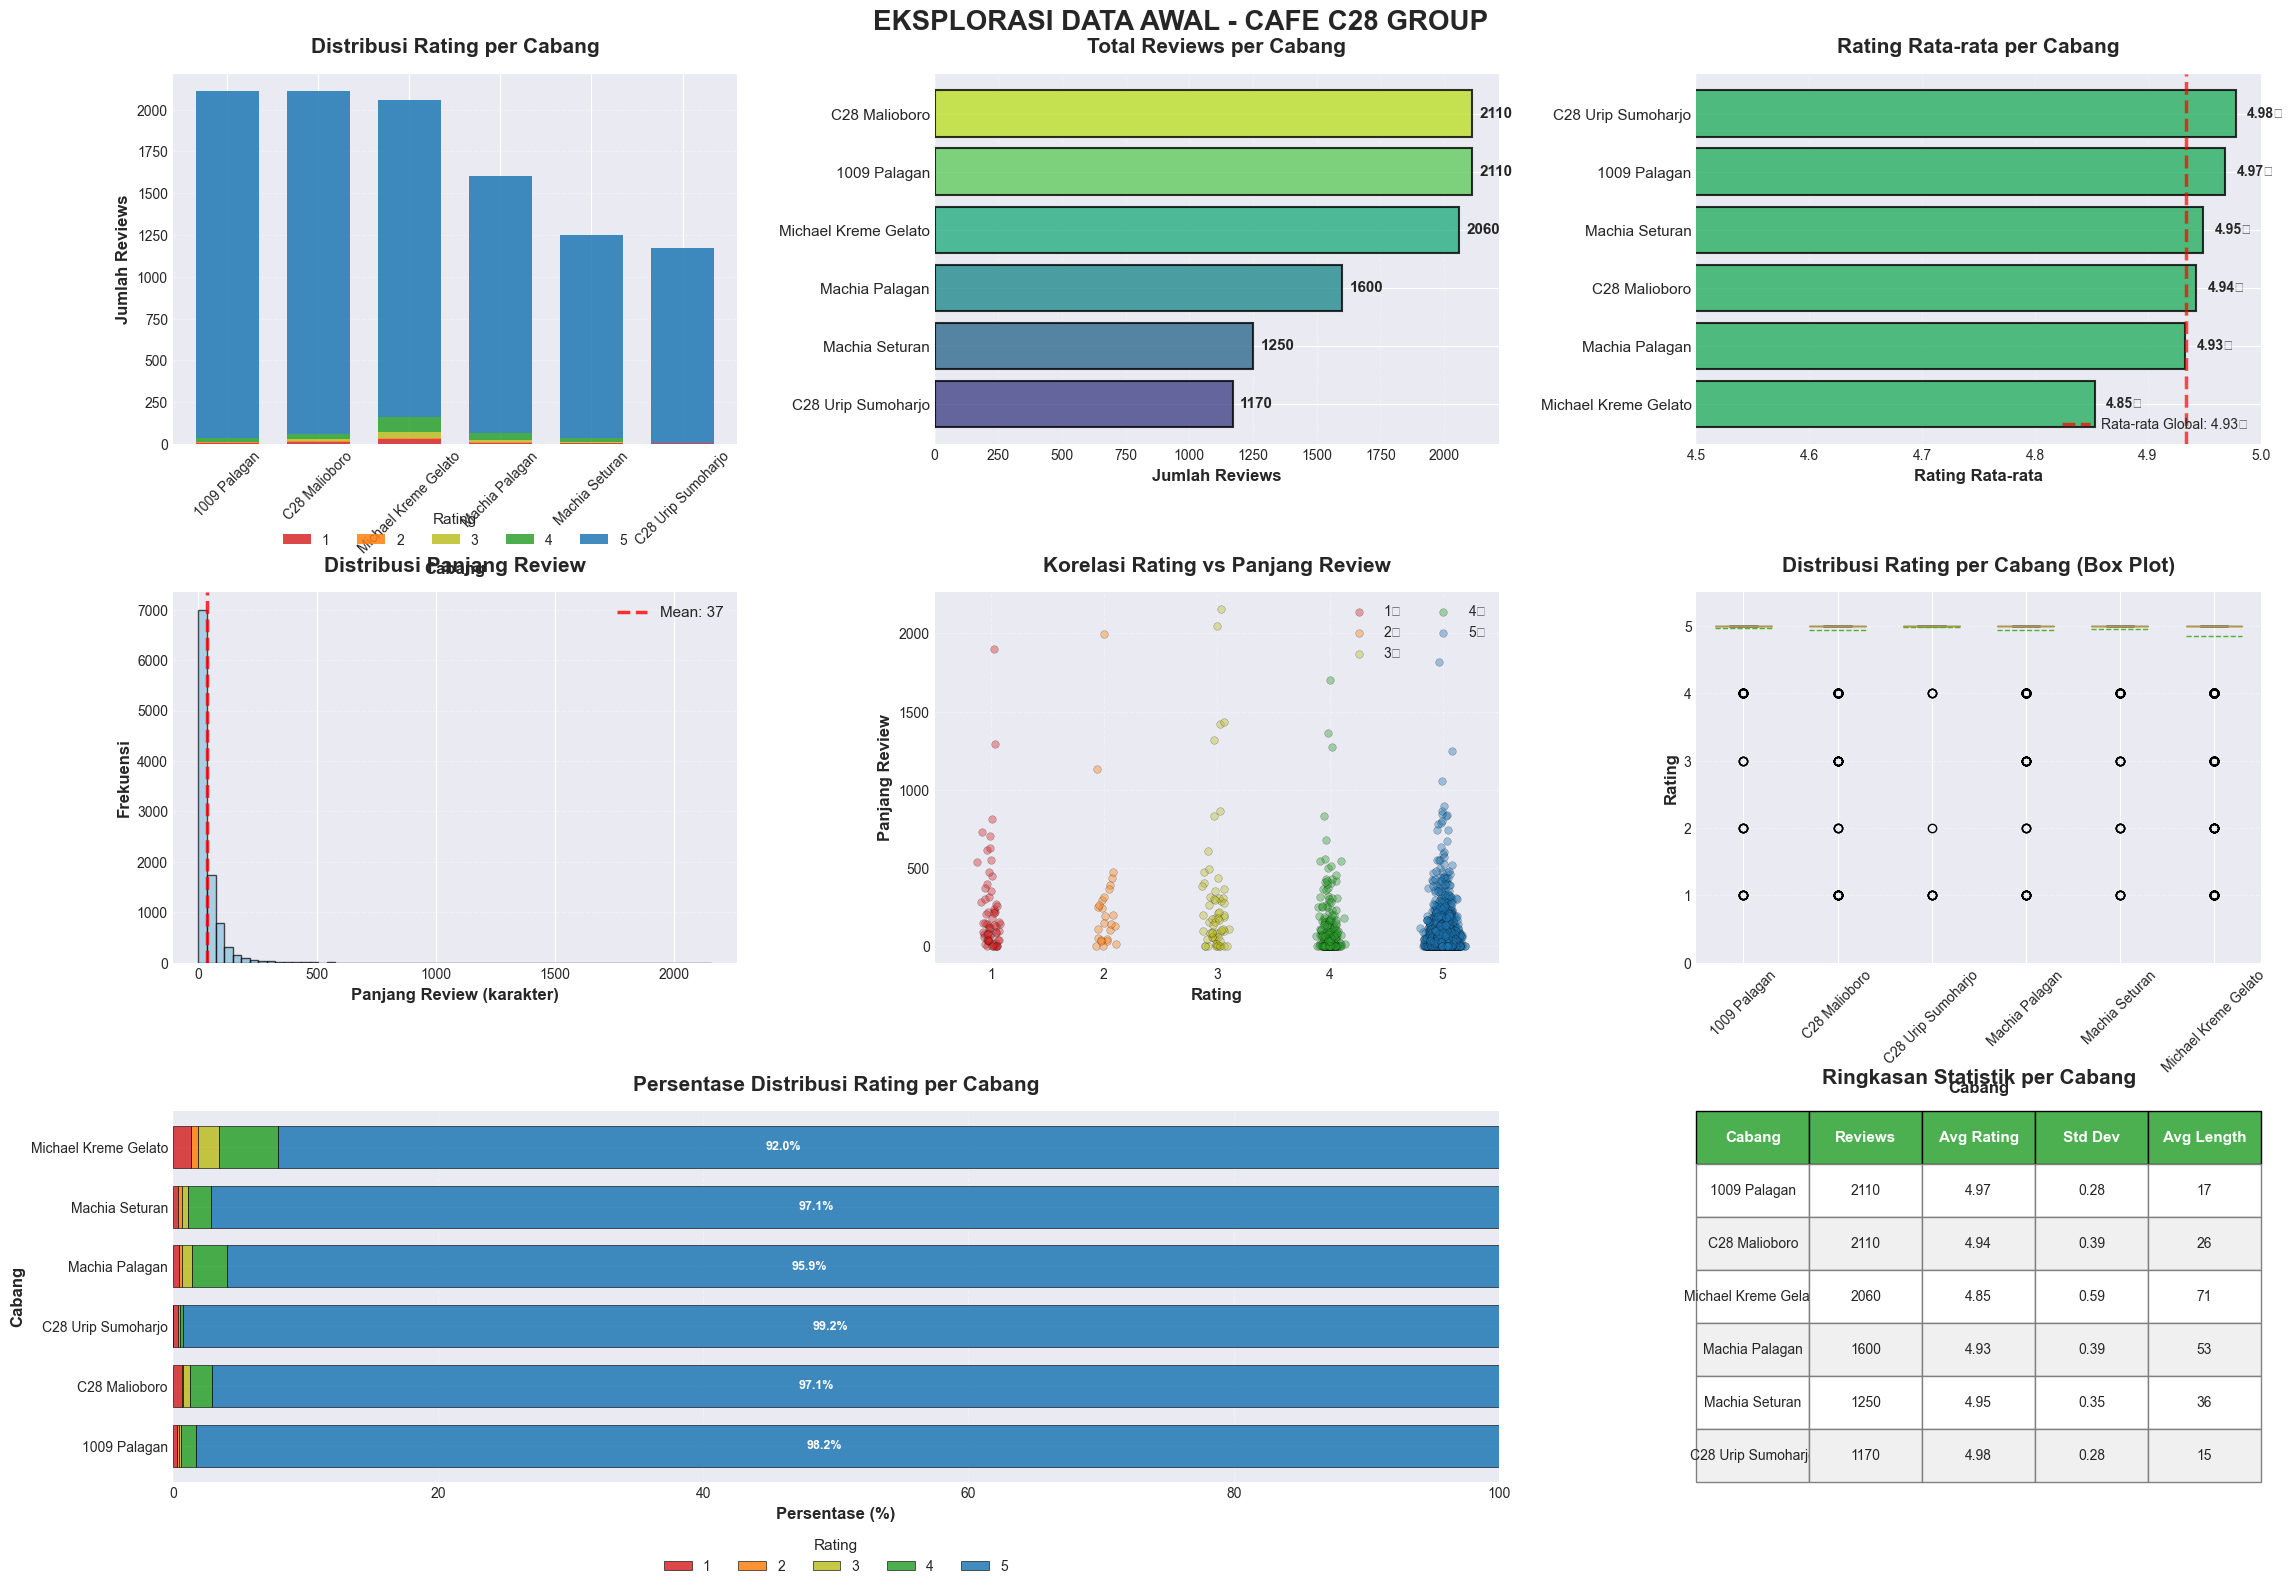

✓ Visualisasi data awal (versi perbaikan) berhasil dibuat!
✓ File disimpan: 00_data_exploration_improved.png


📊 SUMMARY STATISTICS:
------------------------------------------------------------------------------------------
1009 Palagan              | Reviews: 2110   | Avg Rating: 4.97 | Std: 0.28 | Avg Length: 17
C28 Malioboro             | Reviews: 2110   | Avg Rating: 4.94 | Std: 0.39 | Avg Length: 26
Michael Kreme Gelato      | Reviews: 2060   | Avg Rating: 4.85 | Std: 0.59 | Avg Length: 71
Machia Palagan            | Reviews: 1600   | Avg Rating: 4.93 | Std: 0.39 | Avg Length: 53
Machia Seturan            | Reviews: 1250   | Avg Rating: 4.95 | Std: 0.35 | Avg Length: 36
C28 Urip Sumoharjo        | Reviews: 1170   | Avg Rating: 4.98 | Std: 0.28 | Avg Length: 15



In [6]:
# === CELL 3: Visualisasi Data Awal (IMPROVED VERSION) ===
print("📊 CELL 3: VISUALISASI DATA AWAL - VERSI PERBAIKAN")
print("-"*90)

# Set style untuk visualisasi yang lebih baik
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure dengan ukuran lebih besar
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.35, 
                       left=0.08, right=0.95, top=0.94, bottom=0.06)

# ============================================================================
# 1. DISTRIBUSI RATING PER CABANG (Stacked Bar)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
rating_by_branch = df_all.groupby(['cabang', 'rating']).size().unstack(fill_value=0)
# Urutkan berdasarkan total reviews
branch_order = rating_by_branch.sum(axis=1).sort_values(ascending=False).index
rating_by_branch = rating_by_branch.loc[branch_order]

# Warna yang lebih baik untuk rating
colors = ['#d62728', '#ff7f0e', '#bcbd22', '#2ca02c', '#1f77b4']
rating_by_branch.plot(kind='bar', stacked=True, ax=ax1, 
                       color=colors, alpha=0.85, width=0.7)
ax1.set_title('Distribusi Rating per Cabang', fontsize=15, weight='bold', pad=15)
ax1.set_xlabel('Cabang', fontsize=12, weight='bold')
ax1.set_ylabel('Jumlah Reviews', fontsize=12, weight='bold')
ax1.legend(title='Rating', fontsize=10, title_fontsize=11, 
           ncol=5, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# ============================================================================
# 2. TOTAL REVIEWS PER CABANG (Horizontal Bar)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])
review_counts = df_all['cabang'].value_counts().sort_values(ascending=True)
colors_gradient = plt.cm.viridis(np.linspace(0.2, 0.9, len(review_counts)))
bars = ax2.barh(range(len(review_counts)), review_counts.values, 
                color=colors_gradient, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(review_counts)))
ax2.set_yticklabels(review_counts.index, fontsize=11)
ax2.set_xlabel('Jumlah Reviews', fontsize=12, weight='bold')
ax2.set_title('Total Reviews per Cabang', fontsize=15, weight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Tambahkan label nilai
for i, (bar, val) in enumerate(zip(bars, review_counts.values)):
    width = bar.get_width()
    ax2.text(width + 30, i, f'{int(val)}', 
             va='center', fontsize=11, weight='bold')

# ============================================================================
# 3. AVERAGE RATING PER CABANG (Horizontal Bar dengan color coding)
# ============================================================================
ax3 = fig.add_subplot(gs[0, 2])
avg_ratings = df_all.groupby('cabang')['rating'].mean().sort_values(ascending=True)
colors_rating = ['#e74c3c' if x < 4.5 else '#f39c12' if x < 4.8 else '#27ae60' 
                 for x in avg_ratings.values]
bars = ax3.barh(range(len(avg_ratings)), avg_ratings.values, 
                color=colors_rating, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_yticks(range(len(avg_ratings)))
ax3.set_yticklabels(avg_ratings.index, fontsize=11)
ax3.set_xlabel('Rating Rata-rata', fontsize=12, weight='bold')
ax3.set_title('Rating Rata-rata per Cabang', fontsize=15, weight='bold', pad=15)
ax3.set_xlim(4.5, 5.0)
global_mean = df_all['rating'].mean()
ax3.axvline(x=global_mean, color='red', linestyle='--', linewidth=2.5, 
            label=f'Rata-rata Global: {global_mean:.2f}★', alpha=0.7)
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.legend(fontsize=10, loc='lower right')

# Tambahkan label nilai
for i, (bar, val) in enumerate(zip(bars, avg_ratings.values)):
    width = bar.get_width()
    ax3.text(width + 0.01, i, f'{val:.2f}★', 
             va='center', fontsize=10, weight='bold')

# ============================================================================
# 4. DISTRIBUSI PANJANG REVIEW (Histogram)
# ============================================================================
ax4 = fig.add_subplot(gs[1, 0])
df_all['review_length'] = df_all['ulasan'].astype(str).str.len()
n, bins, patches = ax4.hist(df_all['review_length'], bins=60, 
                             color='#3498db', alpha=0.7, edgecolor='black', linewidth=1)
# Warna gradient pada histogram
for i, patch in enumerate(patches):
    patch.set_facecolor(plt.cm.Blues(0.4 + 0.6 * i / len(patches)))

ax4.set_xlabel('Panjang Review (karakter)', fontsize=12, weight='bold')
ax4.set_ylabel('Frekuensi', fontsize=12, weight='bold')
ax4.set_title('Distribusi Panjang Review', fontsize=15, weight='bold', pad=15)
mean_length = df_all['review_length'].mean()
ax4.axvline(mean_length, color='red', linestyle='--', linewidth=2.5, 
            label=f'Mean: {mean_length:.0f}', alpha=0.8)
ax4.legend(fontsize=11, loc='upper right')
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# ============================================================================
# 5. KORELASI RATING VS PANJANG REVIEW (Scatter with jitter)
# ============================================================================
ax5 = fig.add_subplot(gs[1, 1])
colors_scatter = {1: '#d62728', 2: '#ff7f0e', 3: '#bcbd22', 4: '#2ca02c', 5: '#1f77b4'}
for rating in sorted(df_all['rating'].unique()):
    data = df_all[df_all['rating'] == rating]
    # Tambahkan jitter untuk visibilitas lebih baik
    jitter_x = rating + np.random.normal(0, 0.05, len(data))
    ax5.scatter(jitter_x, data['review_length'], 
                alpha=0.4, s=30, color=colors_scatter.get(rating, '#333333'),
                label=f'{rating:.0f}★', edgecolors='black', linewidth=0.3)

ax5.set_xlabel('Rating', fontsize=12, weight='bold')
ax5.set_ylabel('Panjang Review', fontsize=12, weight='bold')
ax5.set_title('Korelasi Rating vs Panjang Review', fontsize=15, weight='bold', pad=15)
ax5.set_xticks(range(1, 6))
ax5.set_xlim(0.5, 5.5)
ax5.legend(fontsize=10, loc='upper right', ncol=2)
ax5.grid(alpha=0.3, linestyle='--')

# ============================================================================
# 6. BOX PLOT RATING PER CABANG (Lebih detail)
# ============================================================================
ax6 = fig.add_subplot(gs[1, 2])
branch_order_box = df_all.groupby('cabang')['rating'].median().sort_values(ascending=False).index
df_sorted = df_all.set_index('cabang').loc[branch_order_box].reset_index()

bp = ax6.boxplot([df_sorted[df_sorted['cabang'] == branch]['rating'].values 
                   for branch in branch_order_box],
                  labels=branch_order_box,
                  patch_artist=True,
                  showmeans=True,
                  meanline=True,
                  widths=0.6)

# Warnai box plot
colors_box = plt.cm.Set3(np.linspace(0, 1, len(branch_order_box)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax6.set_xlabel('Cabang', fontsize=12, weight='bold')
ax6.set_ylabel('Rating', fontsize=12, weight='bold')
ax6.set_title('Distribusi Rating per Cabang (Box Plot)', fontsize=15, weight='bold', pad=15)
ax6.tick_params(axis='x', rotation=45, labelsize=10)
ax6.set_ylim(0, 5.5)
ax6.grid(axis='y', alpha=0.3, linestyle='--')

# ============================================================================
# 7. PERSENTASE RATING PER CABANG (Pie charts atau stacked percentage)
# ============================================================================
ax7 = fig.add_subplot(gs[2, :2])
rating_pct = df_all.groupby(['cabang', 'rating']).size().unstack(fill_value=0)
rating_pct_norm = rating_pct.div(rating_pct.sum(axis=1), axis=0) * 100

# Buat stacked bar horizontal dengan persentase
rating_pct_norm.plot(kind='barh', stacked=True, ax=ax7,
                     color=colors, alpha=0.85, width=0.7, edgecolor='black', linewidth=0.5)

ax7.set_xlabel('Persentase (%)', fontsize=12, weight='bold')
ax7.set_ylabel('Cabang', fontsize=12, weight='bold')
ax7.set_title('Persentase Distribusi Rating per Cabang', fontsize=15, weight='bold', pad=15)
ax7.legend(title='Rating', fontsize=10, title_fontsize=11, 
           ncol=5, loc='upper center', bbox_to_anchor=(0.5, -0.12))
ax7.set_xlim(0, 100)
ax7.grid(axis='x', alpha=0.3, linestyle='--')

# Tambahkan persentase pada bar jika > 5%
for i, cabang in enumerate(rating_pct_norm.index):
    cumulative = 0
    for j, rating in enumerate(rating_pct_norm.columns):
        value = rating_pct_norm.loc[cabang, rating]
        if value > 5:  # Hanya tampilkan jika > 5%
            ax7.text(cumulative + value/2, i, f'{value:.1f}%', 
                    ha='center', va='center', fontsize=9, weight='bold', color='white')

# ============================================================================
# 8. SUMMARY STATISTICS TABLE
# ============================================================================
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

summary_data = []
for cabang in df_all['cabang'].unique():
    df_cab = df_all[df_all['cabang'] == cabang]
    summary_data.append([
        cabang,
        len(df_cab),
        f"{df_cab['rating'].mean():.2f}",
        f"{df_cab['rating'].std():.2f}",
        f"{df_cab['review_length'].mean():.0f}"
    ])

# Urutkan berdasarkan jumlah reviews
summary_data.sort(key=lambda x: int(x[1]), reverse=True)

table = ax8.table(cellText=summary_data,
                  colLabels=['Cabang', 'Reviews', 'Avg Rating', 'Std Dev', 'Avg Length'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for i in range(5):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=11)

# Style cells dengan zebra striping
for i in range(1, len(summary_data) + 1):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        table[(i, j)].set_edgecolor('gray')

ax8.set_title('Ringkasan Statistik per Cabang', fontsize=15, weight='bold', pad=20)

# ============================================================================
# FINAL TOUCHES
# ============================================================================
plt.suptitle('EKSPLORASI DATA AWAL - CAFE C28 GROUP', 
             fontsize=20, weight='bold', y=0.98)

# Simpan dengan kualitas tinggi
plt.savefig('00_data_exploration_improved.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("✓ Visualisasi data awal (versi perbaikan) berhasil dibuat!")
print("✓ File disimpan: 00_data_exploration_improved.png")
print(f"{'='*90}\n")

# Tampilkan summary statistics di console
print("\n📊 SUMMARY STATISTICS:")
print("-"*90)
for row in summary_data:
    print(f"{row[0]:<25} | Reviews: {row[1]:<6} | Avg Rating: {row[2]} | Std: {row[3]} | Avg Length: {row[4]}")
print(f"{'='*90}\n")

In [7]:
# ===================================================================
# BAGIAN 2: TEXT PREPROCESSING
# ===================================================================
print("\n" + "="*90)
print("🔧 CELL 4: TEXT PREPROCESSING")
print("-"*90)

# Stopwords Indonesia (Extended)
stopwords = set([
    'yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua',
    'ia', 'seperti', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena',
    'oleh', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'akan',
    'dalam', 'dengan', 'ada', 'atau', 'mereka', 'itu', 'sudah', 'saya', 'nya',
    'kan', 'juga', 'sih', 'aja', 'nih', 'deh', 'dong', 'lah', 'kah', 'pun', 'kok',
    'yg', 'dgn', 'utk', 'krn', 'sdh', 'jd', 'gt', 'gitu', 'gini', 'apa', 'kami',
    'kita', 'kamu', 'anda', 'kalian', 'beliau', 'kalo', 'kalau', 'bila', 'bisa',
    'dapat', 'boleh', 'harus', 'mau', 'ingin', 'perlu', 'biar', 'agar', 'supaya',
    'tapi', 'tetapi', 'melainkan', 'sedangkan', 'padahal', 'bahwa', 'yaitu'
])

print(f"✓ Loaded {len(stopwords)} stopwords")


🔧 CELL 4: TEXT PREPROCESSING
------------------------------------------------------------------------------------------
✓ Loaded 84 stopwords


In [8]:
# Normalisasi kata gaul/typo (Extended)
slang_dict = {
    # Umum
    'bgt': 'banget', 'banget2': 'banget', 'bgt2': 'banget', 'bgtt': 'banget',
    'ga': 'tidak', 'gak': 'tidak', 'ngga': 'tidak', 'gk': 'tidak', 'g': 'tidak',
    'tdk': 'tidak', 'engga': 'tidak', 'nggak': 'tidak', 'gaa': 'tidak',
    
    # Makanan
    'enk': 'enak', 'enaq': 'enak', 'uenak': 'enak', 'enakk': 'enak', 'enak2': 'enak',
    'mkn': 'makan', 'mknan': 'makanan', 'mnm': 'minum', 'mnuman': 'minuman',
    'kopi': 'kopi', 'kpe': 'kopi', 'coffe': 'kopi', 'coffee': 'kopi', 'kopii': 'kopi',
    'mie': 'mie', 'mi': 'mie', 'mee': 'mie',
    
    # Penilaian positif
    'mantul': 'mantap', 'mantap2': 'mantap', 'mntp': 'mantap', 'mantep': 'mantap',
    'mantapp': 'mantap', 'mantab': 'mantap', 'mantabs': 'mantap',
    'rekomend': 'recommended', 'rekomen': 'recommended', 'rekom': 'recommended',
    'recommended': 'recommended', 'recomen': 'recommended',
    'oke': 'oke', 'okeh': 'oke', 'ok': 'oke', 'okay': 'oke', 'okey': 'oke',
    'top': 'bagus', 'toped': 'bagus', 'toop': 'bagus',
    'jos': 'bagus', 'josss': 'bagus', 'joss': 'bagus', 'jooss': 'bagus',
    'ciamik': 'bagus', 'cihuy': 'bagus', 'kece': 'bagus', 'keren': 'bagus',
    'maknyus': 'enak', 'maknyoss': 'enak', 'mantul': 'mantap',
    'poll': 'banget', 'bangett': 'banget', 'bingit': 'banget',
    
    # Penilaian negatif
    'zonk': 'buruk', 'jelek': 'buruk', 'jlek': 'buruk', 'jelekk': 'buruk',
    'mahal': 'mahal', 'mehong': 'mahal', 'pricey': 'mahal',
    
    # Singkatan
    'tp': 'tapi', 'yg': 'yang', 'dgn': 'dengan', 'utk': 'untuk', 'sy': 'saya',
    'dpt': 'dapat', 'org': 'orang', 'jd': 'jadi', 'krn': 'karena', 'sdh': 'sudah',
    'blm': 'belum', 'hrs': 'harus', 'trs': 'terus', 'sm': 'sama', 'tmpt': 'tempat',
    'hrg': 'harga', 'plg': 'paling', 'krng': 'kurang', 'byk': 'banyak', 'sgt': 'sangat',
    'lg': 'lagi', 'jg': 'juga', 'jgn': 'jangan', 'mgkn': 'mungkin', 'skrg': 'sekarang',
    
    # Filler
    'wkwk': '', 'wkwkwk': '', 'wkwkw': '', 'kwkw': '', 'wkk': '',
    'haha': '', 'hahaha': '', 'hihi': '', 'hihihi': '', 'hehe': '', 'hehehe': '',
    'euy': '', 'deh': '', 'dong': '', 'nih': '', 'tuh': '', 'sih': '',
    'yoi': '', 'yap': '', 'yup': '', 'woi': '', 'cuy': '', 'guys': ''
}

print(f"✓ Loaded {len(slang_dict)} slang normalizations")

✓ Loaded 118 slang normalizations


In [9]:
# Initialize Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()
print("✓ Stemmer initialized (Sastrawi)")

def preprocess_text(text):
    """
    Comprehensive text preprocessing pipeline
    """
    if pd.isna(text) or str(text).strip() == '':
        return ''
    
    text = str(text).lower()
    
    # 1. Remove URLs, emails, mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # 3. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 4. Remove non-ASCII
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # 5. Remove punctuation & special chars
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 6. Normalize repeated characters (eenaaak -> enak)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    # 7. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 8. Tokenization
    tokens = text.split()
    
    # 9. Slang normalization
    tokens = [slang_dict.get(word, word) for word in tokens]
    
    # 10. Remove empty tokens
    tokens = [word for word in tokens if word]
    
    # 11. Remove short words (<= 3 chars)
    tokens = [word for word in tokens if len(word) > 3]
    
    # 12. Stopword removal
    tokens = [word for word in tokens if word not in stopwords]
    
    # 13. Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # 14. Remove duplicates in sequence
    result = []
    prev = None
    for token in tokens:
        if token != prev:
            result.append(token)
            prev = token
    
    return ' '.join(result)

print("\n🔄 Processing text...")
print("   Step 1: Cleaning & normalizing...")

✓ Stemmer initialized (Sastrawi)

🔄 Processing text...
   Step 1: Cleaning & normalizing...


In [10]:
# Sample preprocessing
sample_texts = [
    "Kopinya enaakk bgttt! Recommendedd poll 😍",
    "Harganya mahal bgt tp rasanya biasa aja sih",
    "Tempatnya cozy, pelayanannya ramah, makanannya enak2"
]

print("\n📝 SAMPLE PREPROCESSING:")
for i, text in enumerate(sample_texts, 1):
    cleaned = preprocess_text(text)
    print(f"   {i}. Original : {text}")
    print(f"      Cleaned  : {cleaned}\n")


📝 SAMPLE PREPROCESSING:
   1. Original : Kopinya enaakk bgttt! Recommendedd poll 😍
      Cleaned  : kopi enaakk banget recommendedd banget

   2. Original : Harganya mahal bgt tp rasanya biasa aja sih
      Cleaned  : harga mahal banget rasa biasa

   3. Original : Tempatnya cozy, pelayanannya ramah, makanannya enak2
      Cleaned  : tempat cozy layan ramah makan enak



In [11]:
# Apply preprocessing
df_all['ulasan_clean'] = df_all['ulasan'].apply(preprocess_text)

# Remove empty reviews
initial_count = len(df_all)
df_all = df_all[df_all['ulasan_clean'].str.strip() != ''].reset_index(drop=True)
removed_count = initial_count - len(df_all)

print(f"✓ Text preprocessing completed!")
print(f"   • Initial reviews    : {initial_count:,}")
print(f"   • After cleaning     : {len(df_all):,}")
print(f"   • Removed (empty)    : {removed_count:,}")
print(f"\n{'='*90}\n")

✓ Text preprocessing completed!
   • Initial reviews    : 10,300
   • After cleaning     : 5,393
   • Removed (empty)    : 4,907




In [12]:
# ===================================================================
# BAGIAN 3: SENTIMENT LABELING
# ===================================================================
print("\n" + "="*90)
print("🏷️  CELL 5: SENTIMENT LABELING")
print("-"*90)

# Lexicon positif (Comprehensive)
positive_words = set([
    'enak', 'lezat', 'nikmat', 'sedap', 'mantap', 'bagus', 'recommended',
    'suka', 'puas', 'nyaman', 'ramah', 'bersih', 'fresh', 'segar', 'murah',
    'worth', 'terbaik', 'favorit', 'istimewa', 'sempurna', 'cocok', 'keren',
    'baik', 'senang', 'cinta', 'love', 'perfect', 'delicious', 'amazing',
    'excellent', 'great', 'good', 'best', 'cozy', 'rekomendasi', 'oke',
    'cantik', 'indah', 'aesthetic', 'instagramable', 'kece', 'ciamik',
    'juara', 'lengkap', 'varian', 'bervariasi', 'cepat', 'pelayanan',
    'luas', 'nyaman', 'sejuk', 'adem', 'tenang', 'asri', 'bersih',
    'rapi', 'tertib', 'teratur', 'terorganisir', 'profesional',
    'responsif', 'sigap', 'tanggap', 'solutif', 'membantu',
    'lembut', 'halus', 'creamy', 'manis', 'gurih', 'crispy', 'renyah'
])

negative_words = set([
    'buruk', 'jelek', 'mahal', 'kecewa', 'lambat', 'lama', 'dingin', 'basi',
    'hambar', 'kotor', 'jorok', 'pahit', 'keras', 'asin', 'mengecewakan',
    'zonk', 'kurang', 'tidak', 'bad', 'terrible', 'worst', 'poor',
    'disappointing', 'overpriced', 'slow', 'lelet', 'overprice',
    'panas', 'meleleh', 'beku', 'tawar', 'gosong', 'mentah', 'anyir',
    'amis', 'tengik', 'apek', 'bau', 'busuk', 'kadaluarsa',
    'sempit', 'sesak', 'pengap', 'panas', 'gerah', 'bising', 'ramai',
    'rusak', 'kotor', 'kusam', 'lusuh', 'dekil', 'kumuh',
    'kasar', 'jutek', 'galak', 'sombong', 'cuek', 'acuh',
    'lama', 'telat', 'lambat', 'waiting', 'antri', 'mengantri'
])

print(f"✓ Positive lexicon: {len(positive_words)} words")
print(f"✓ Negative lexicon: {len(negative_words)} words")



🏷️  CELL 5: SENTIMENT LABELING
------------------------------------------------------------------------------------------
✓ Positive lexicon: 70 words
✓ Negative lexicon: 61 words


In [13]:
def calculate_sentiment_score(text):
    """Calculate sentiment score from text"""
    words = str(text).lower().split()
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    return pos_count, neg_count

def label_sentiment(row):
    """
    Hybrid sentiment labeling: Lexicon + Rating
    """
    text = str(row['ulasan_clean']).lower()
    rating = row['rating']
    
    pos_count, neg_count = calculate_sentiment_score(text)
    
    # Rating-based classification with lexicon adjustment
    if rating >= 4:
        if neg_count > pos_count + 2:
            return 'negatif'
        elif pos_count >= neg_count:
            return 'positif'
        else:
            return 'netral'
    elif rating <= 2:
        if pos_count > neg_count + 2:
            return 'positif'
        elif neg_count >= pos_count:
            return 'negatif'
        else:
            return 'netral'
    else:  # rating == 3
        if pos_count > neg_count + 1:
            return 'positif'
        elif neg_count > pos_count + 1:
            return 'negatif'
        else:
            return 'netral'

# Apply sentiment labeling
print("\n🔄 Applying sentiment labeling...")
df_all['sentiment'] = df_all.apply(label_sentiment, axis=1)
df_all['pos_words'] = df_all['ulasan_clean'].apply(lambda x: calculate_sentiment_score(x)[0])
df_all['neg_words'] = df_all['ulasan_clean'].apply(lambda x: calculate_sentiment_score(x)[1])

print("✓ Sentiment labeling completed!")


🔄 Applying sentiment labeling...
✓ Sentiment labeling completed!


In [14]:
print("\n📊 SENTIMENT DISTRIBUTION:")
sentiment_counts = df_all['sentiment'].value_counts()
sentiment_pct = (sentiment_counts / len(df_all) * 100).round(2)

for sent in ['positif', 'netral', 'negatif']:
    if sent in sentiment_counts.index:
        count = sentiment_counts[sent]
        pct = sentiment_pct[sent]
        bar = '█' * int(pct)
        icon = '😊' if sent == 'positif' else '😐' if sent == 'netral' else '😞'
        print(f"   {icon} {sent.capitalize():10s}: {bar:50s} {count:5d} ({pct:5.1f}%)")

print("\n📈 SENTIMENT STATISTICS PER CABANG:")
sentiment_by_branch = df_all.groupby(['cabang', 'sentiment']).size().unstack(fill_value=0)
sentiment_pct_branch = (sentiment_by_branch.div(sentiment_by_branch.sum(axis=1), axis=0) * 100).round(2)
sentiment_pct_branch = sentiment_pct_branch[['positif', 'netral', 'negatif']]

print(sentiment_pct_branch.to_string())

print(f"\n{'='*90}\n")


📊 SENTIMENT DISTRIBUTION:
   😊 Positif   : █████████████████████████████████████████████████████████████████████████████████████████████████  5261 ( 97.5%)
   😐 Netral    : █                                                     77 (  1.4%)
   😞 Negatif   : █                                                     55 (  1.0%)

📈 SENTIMENT STATISTICS PER CABANG:
sentiment             positif  netral  negatif
cabang                                        
1009 Palagan            98.91    0.55     0.55
C28 Malioboro           97.09    2.06     0.84
C28 Urip Sumoharjo      98.42    0.00     1.58
Machia Palagan          98.24    1.32     0.44
Machia Seturan          98.40    0.87     0.73
Michael Kreme Gelato    96.09    2.06     1.85





📊 CELL 6: VISUALISASI OVERVIEW SENTIMEN
------------------------------------------------------------------------------------------


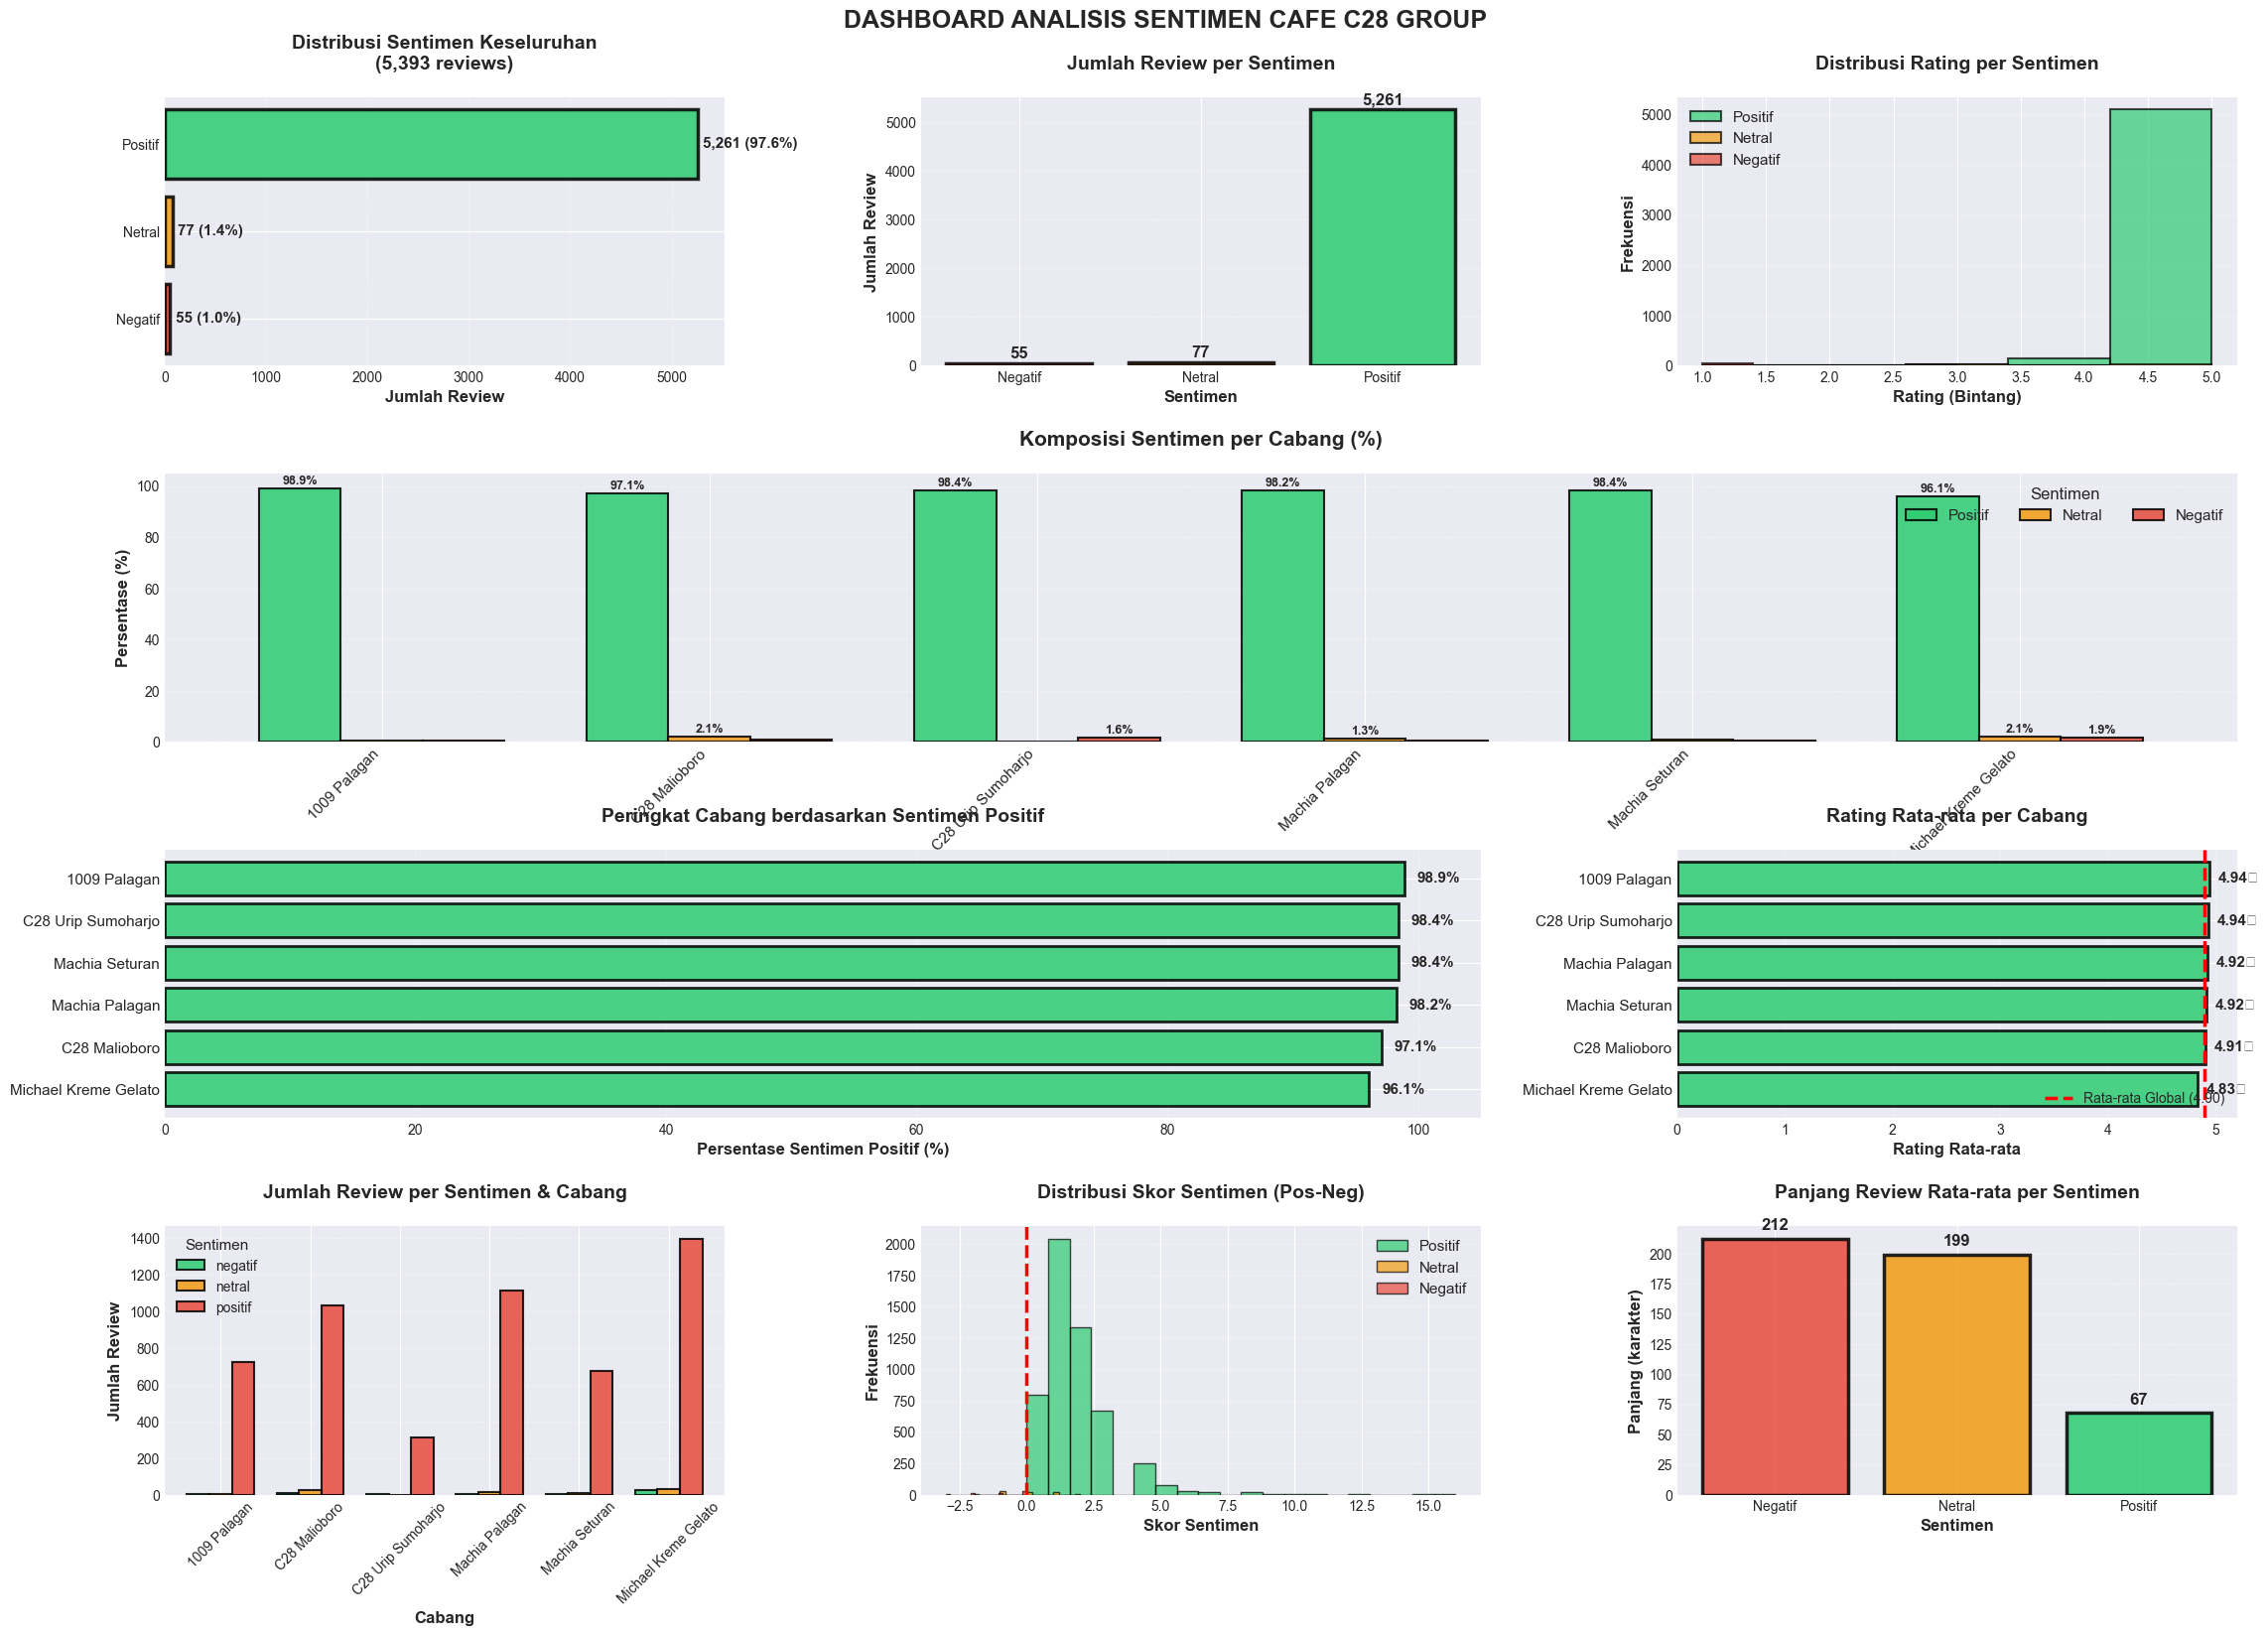

✓ Visualisasi overview sentimen berhasil: 01_sentiment_overview.png



In [15]:
# ===================================================================
# BAGIAN 4: VISUALISASI SENTIMEN KOMPREHENSIF (IMPROVED)
# ===================================================================

# === CELL 6: Overview Sentimen ===
print("\n" + "="*90)
print("📊 CELL 6: VISUALISASI OVERVIEW SENTIMEN")
print("-"*90)

colors_sentiment = {'positif': '#2ecc71', 'netral': '#f39c12', 'negatif': '#e74c3c'}

fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35, 
                      left=0.08, right=0.95, top=0.94, bottom=0.06)

# 6.1 Overall Sentiment Bar Chart (Horizontal)
ax1 = fig.add_subplot(gs[0, 0])
sentiment_counts = df_all['sentiment'].value_counts().sort_values(ascending=True)
colors = [colors_sentiment[x] for x in sentiment_counts.index]
bars = ax1.barh([s.capitalize() for s in sentiment_counts.index], 
                sentiment_counts.values, color=colors, alpha=0.85, 
                edgecolor='black', linewidth=2.5)
ax1.set_title(f'Distribusi Sentimen Keseluruhan\n({len(df_all):,} reviews)', 
              fontsize=14, weight='bold', pad=20)
ax1.set_xlabel('Jumlah Review', fontsize=12, weight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add value and percentage labels
total = sentiment_counts.sum()
for bar, val in zip(bars, sentiment_counts.values):
    pct = (val/total)*100
    ax1.text(val + 50, bar.get_y() + bar.get_height()/2,
             f'{int(val):,} ({pct:.1f}%)', va='center', fontsize=11, weight='bold')

# 6.2 Sentiment Count Bar
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar([s.capitalize() for s in sentiment_counts.index], 
               sentiment_counts.values, color=colors, alpha=0.85, 
               edgecolor='black', linewidth=2.5)
ax2.set_title('Jumlah Review per Sentimen', fontsize=14, weight='bold', pad=20)
ax2.set_ylabel('Jumlah Review', fontsize=12, weight='bold')
ax2.set_xlabel('Sentimen', fontsize=12, weight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax2.set_axisbelow(True)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}', ha='center', va='bottom', 
             fontsize=12, weight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# 6.3 Rating Distribution by Sentiment
ax3 = fig.add_subplot(gs[0, 2])
for sent in ['positif', 'netral', 'negatif']:
    data = df_all[df_all['sentiment'] == sent]['rating']
    ax3.hist(data, bins=5, alpha=0.7, label=sent.capitalize(), 
             color=colors_sentiment[sent], edgecolor='black', linewidth=1.5)
ax3.set_title('Distribusi Rating per Sentimen', fontsize=14, weight='bold', pad=20)
ax3.set_xlabel('Rating (Bintang)', fontsize=12, weight='bold')
ax3.set_ylabel('Frekuensi', fontsize=12, weight='bold')
ax3.legend(fontsize=11, framealpha=0.9)
ax3.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax3.set_axisbelow(True)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# 6.4 Sentiment per Branch (Grouped Bar Chart)
ax4 = fig.add_subplot(gs[1, :])
x = np.arange(len(sentiment_pct_branch))
width = 0.25

for idx, col in enumerate(['positif', 'netral', 'negatif']):
    offset = (idx - 1) * width
    bars = ax4.bar(x + offset, sentiment_pct_branch[col], width,
                   label=col.capitalize(), color=colors_sentiment[col], 
                   alpha=0.85, edgecolor='black', linewidth=1.5)
    
    # Add percentage labels on top of bars
    for i, (bar, v) in enumerate(zip(bars, sentiment_pct_branch[col])):
        if v > 1:  # Only show labels for values > 1%
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{v:.1f}%', ha='center', va='bottom', 
                    fontsize=9, weight='bold', rotation=0)

ax4.set_title('Komposisi Sentimen per Cabang (%)', fontsize=15, weight='bold', pad=20)
ax4.set_ylabel('Persentase (%)', fontsize=12, weight='bold')
ax4.set_xlabel('Cabang', fontsize=12, weight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(sentiment_pct_branch.index, rotation=45, ha='right', fontsize=11)
ax4.legend(title='Sentimen', loc='upper right', fontsize=11, title_fontsize=12, 
           framealpha=0.9, ncol=3)
ax4.set_ylim(0, 105)
ax4.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax4.set_axisbelow(True)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# 6.5 Top Branches by Positive %
ax5 = fig.add_subplot(gs[2, :2])
top_positive = sentiment_pct_branch['positif'].sort_values(ascending=True)
bars = ax5.barh(range(len(top_positive)), top_positive.values, 
                color='#2ecc71', alpha=0.85, edgecolor='black', linewidth=2)
ax5.set_yticks(range(len(top_positive)))
ax5.set_yticklabels(top_positive.index, fontsize=11)
ax5.set_xlabel('Persentase Sentimen Positif (%)', fontsize=12, weight='bold')
ax5.set_title('Peringkat Cabang berdasarkan Sentimen Positif', 
              fontsize=14, weight='bold', pad=20)
ax5.set_xlim(0, 105)
ax5.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
ax5.set_axisbelow(True)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

for i, (bar, val) in enumerate(zip(bars, top_positive.values)):
    ax5.text(val + 1, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}%', va='center', fontsize=11, weight='bold')

# 6.6 Average Rating per Branch
ax6 = fig.add_subplot(gs[2, 2])
avg_rating_branch = df_all.groupby('cabang')['rating'].mean().sort_values(ascending=True)
colors_rating = ['#e74c3c' if x < 3.5 else '#f39c12' if x < 4 else '#2ecc71' 
                 for x in avg_rating_branch.values]
bars = ax6.barh(range(len(avg_rating_branch)), avg_rating_branch.values, 
                color=colors_rating, alpha=0.85, edgecolor='black', linewidth=2)
ax6.set_yticks(range(len(avg_rating_branch)))
ax6.set_yticklabels(avg_rating_branch.index, fontsize=11)
ax6.set_xlabel('Rating Rata-rata', fontsize=12, weight='bold')
ax6.set_title('Rating Rata-rata per Cabang', fontsize=14, weight='bold', pad=20)
ax6.set_xlim(0, 5.2)
avg_global = df_all['rating'].mean()
ax6.axvline(x=avg_global, color='red', linestyle='--', linewidth=2.5, 
            label=f'Rata-rata Global ({avg_global:.2f})')
ax6.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
ax6.set_axisbelow(True)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

for i, (bar, val) in enumerate(zip(bars, avg_rating_branch.values)):
    ax6.text(val + 0.08, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}★', va='center', fontsize=11, weight='bold')
ax6.legend(fontsize=10, loc='lower right')

# 6.7 Sentiment vs Review Count
ax7 = fig.add_subplot(gs[3, 0])
review_counts_by_sent = df_all.groupby(['cabang', 'sentiment']).size().unstack(fill_value=0)
review_counts_by_sent.plot(kind='bar', ax=ax7, 
                          color=[colors_sentiment['positif'], 
                                colors_sentiment['netral'], 
                                colors_sentiment['negatif']], 
                          alpha=0.85, edgecolor='black', linewidth=1.5, width=0.75)
ax7.set_title('Jumlah Review per Sentimen & Cabang', fontsize=14, weight='bold', pad=20)
ax7.set_xlabel('Cabang', fontsize=12, weight='bold')
ax7.set_ylabel('Jumlah Review', fontsize=12, weight='bold')
ax7.legend(title='Sentimen', fontsize=10, title_fontsize=11, framealpha=0.9)
ax7.tick_params(axis='x', rotation=45, labelsize=10)
ax7.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax7.set_axisbelow(True)
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)

# 6.8 Sentiment Score Distribution
ax8 = fig.add_subplot(gs[3, 1])
df_all['sentiment_score'] = df_all['pos_words'] - df_all['neg_words']
for sent in ['positif', 'netral', 'negatif']:
    data = df_all[df_all['sentiment'] == sent]['sentiment_score']
    ax8.hist(data, bins=20, alpha=0.7, label=sent.capitalize(), 
             color=colors_sentiment[sent], edgecolor='black', linewidth=1)
ax8.set_title('Distribusi Skor Sentimen (Pos-Neg)', fontsize=14, weight='bold', pad=20)
ax8.set_xlabel('Skor Sentimen', fontsize=12, weight='bold')
ax8.set_ylabel('Frekuensi', fontsize=12, weight='bold')
ax8.legend(fontsize=11, framealpha=0.9)
ax8.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Netral Point')
ax8.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax8.set_axisbelow(True)
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)

# 6.9 Review Length by Sentiment
ax9 = fig.add_subplot(gs[3, 2])
sentiment_length = df_all.groupby('sentiment')['review_length'].mean()
bars = ax9.bar([s.capitalize() for s in sentiment_length.index], 
               sentiment_length.values, 
               color=[colors_sentiment[x] for x in sentiment_length.index], 
               alpha=0.85, edgecolor='black', linewidth=2.5)
ax9.set_title('Panjang Review Rata-rata per Sentimen', fontsize=14, weight='bold', pad=20)
ax9.set_ylabel('Panjang (karakter)', fontsize=12, weight='bold')
ax9.set_xlabel('Sentimen', fontsize=12, weight='bold')
ax9.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax9.set_axisbelow(True)
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)

for bar in bars:
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', 
             fontsize=12, weight='bold')

plt.suptitle('DASHBOARD ANALISIS SENTIMEN CAFE C28 GROUP', 
             fontsize=18, weight='bold', y=0.995)
plt.savefig('01_sentiment_overview.png', dpi=400, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("✓ Visualisasi overview sentimen berhasil: 01_sentiment_overview.png")
print(f"{'='*90}\n")


📊 CELL 7: PERBANDINGAN DETAIL PER CABANG
------------------------------------------------------------------------------------------


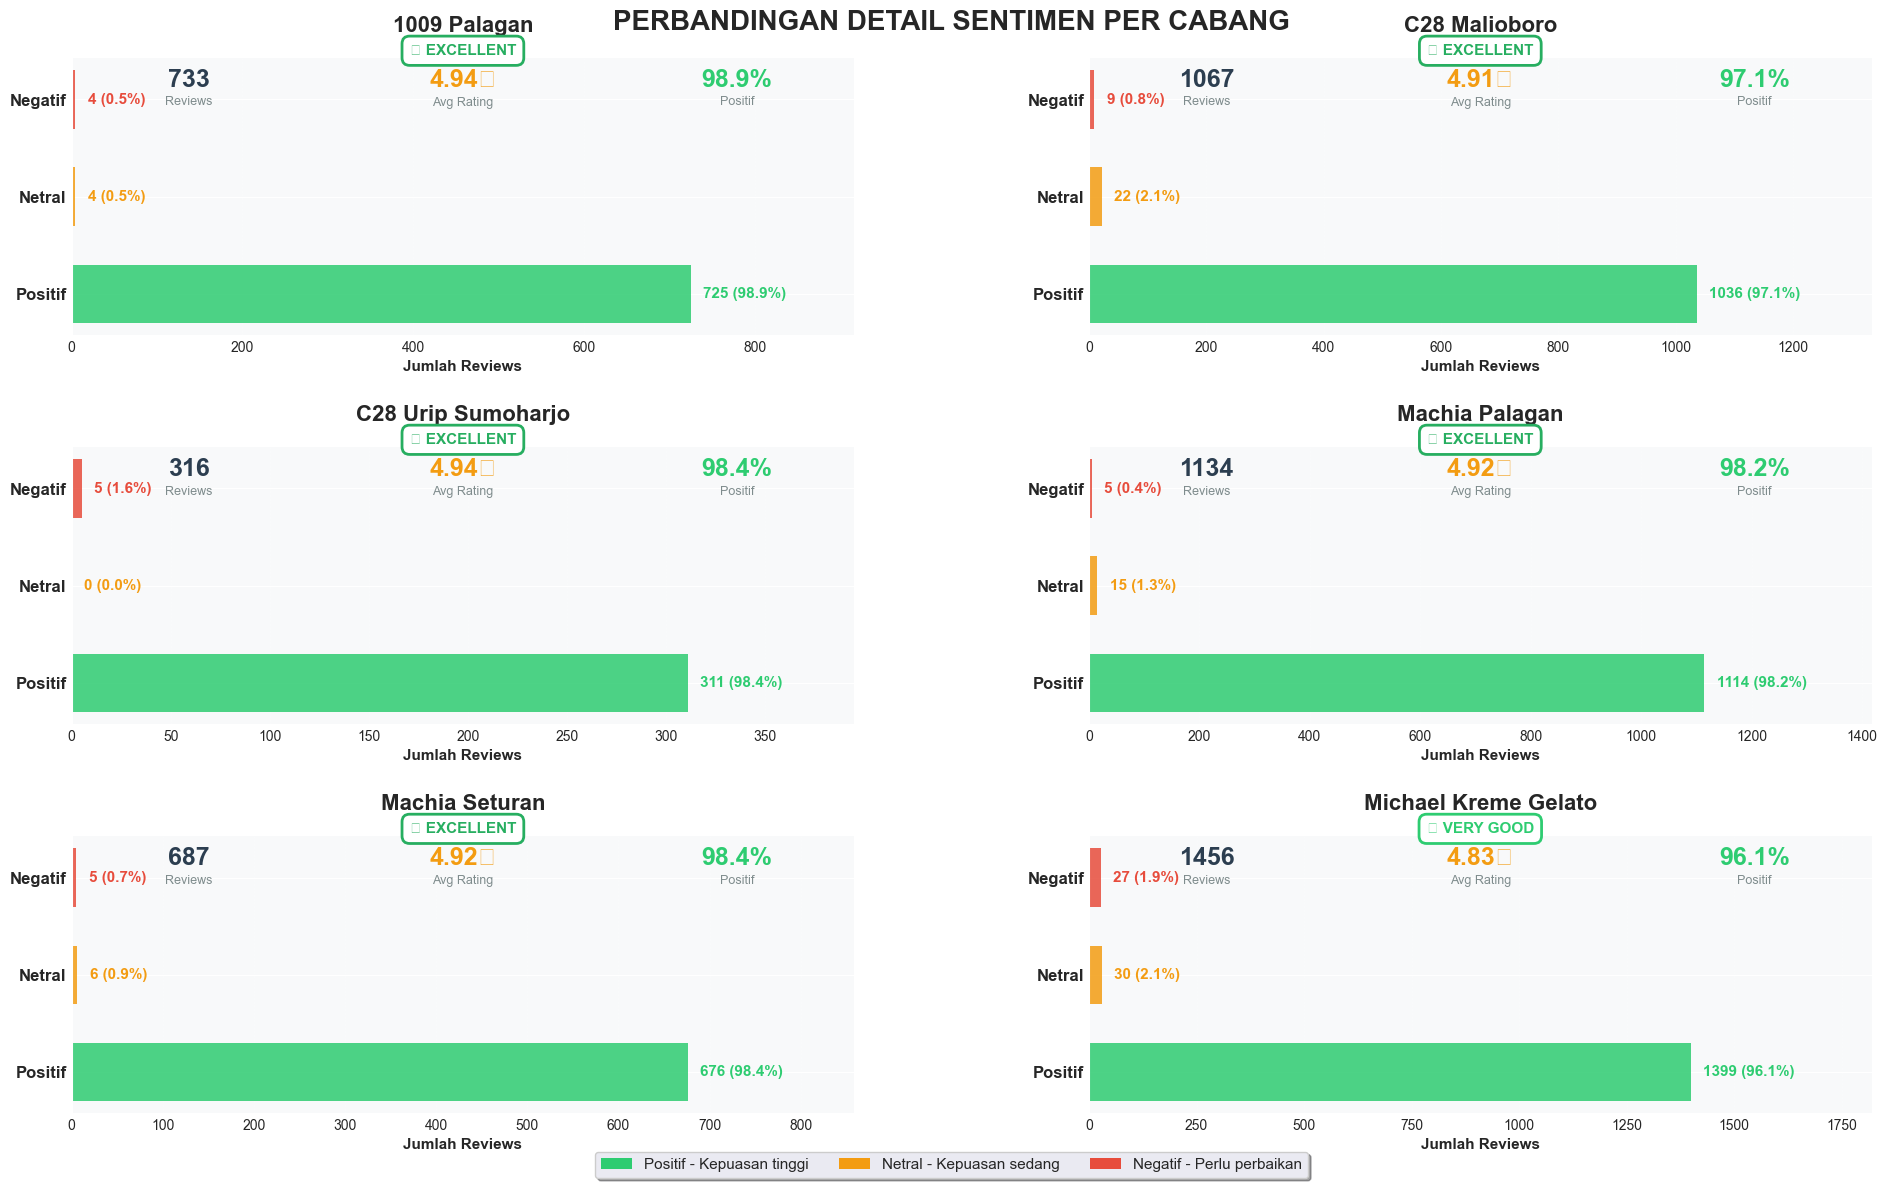

✓ Visualisasi perbandingan cabang berhasil: 02_branch_comparison.png


RINGKASAN PERFORMA CABANG:
------------------------------------------------------------------------------------------
Cabang                            Total   Avg Rating    Positif     Netral    Negatif
------------------------------------------------------------------------------------------
1009 Palagan                        733        4.94★      98.9%       0.5%       0.5%
C28 Urip Sumoharjo                  316        4.94★      98.4%       0.0%       1.6%
Machia Seturan                      687        4.92★      98.4%       0.9%       0.7%
Machia Palagan                     1134        4.92★      98.2%       1.3%       0.4%
C28 Malioboro                      1067        4.91★      97.1%       2.1%       0.8%
Michael Kreme Gelato               1456        4.83★      96.1%       2.1%       1.9%
------------------------------------------------------------------------------------------


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# === CELL 7: Detailed Branch Comparison (IMPROVED) ===
print("\n" + "="*90)
print("📊 CELL 7: PERBANDINGAN DETAIL PER CABANG")
print("-"*90)

# Prepare data
branches = sorted(df_all['cabang'].unique())
branch_stats = []

for cabang in branches:
    df_cabang = df_all[df_all['cabang'] == cabang]
    sentiment_dist = df_cabang['sentiment'].value_counts()
    total = len(df_cabang)
    
    stats = {
        'cabang': cabang,
        'total_reviews': total,
        'avg_rating': df_cabang['rating'].mean(),
        'positif': sentiment_dist.get('positif', 0),
        'netral': sentiment_dist.get('netral', 0),
        'negatif': sentiment_dist.get('negatif', 0),
        'positif_pct': (sentiment_dist.get('positif', 0) / total * 100),
        'netral_pct': (sentiment_dist.get('netral', 0) / total * 100),
        'negatif_pct': (sentiment_dist.get('negatif', 0) / total * 100)
    }
    branch_stats.append(stats)

# Create figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3, top=0.93, bottom=0.05, left=0.06, right=0.96)

fig.suptitle('PERBANDINGAN DETAIL SENTIMEN PER CABANG', 
             fontsize=20, weight='bold', y=0.97)

# Colors
color_positif = '#2ecc71'
color_netral = '#f39c12'
color_negatif = '#e74c3c'

for idx, stats in enumerate(branch_stats):
    row = idx // 2
    col = idx % 2
    
    # Create subplot
    ax = fig.add_subplot(gs[row, col])
    
    # Determine performance level
    pos_pct = stats['positif_pct']
    if pos_pct >= 97:
        perf = 'EXCELLENT'
        perf_color = '#27ae60'
        perf_icon = '🏆'
    elif pos_pct >= 95:
        perf = 'VERY GOOD'
        perf_color = '#2ecc71'
        perf_icon = '⭐'
    elif pos_pct >= 90:
        perf = 'GOOD'
        perf_color = '#3498db'
        perf_icon = '✓'
    else:
        perf = 'NEEDS IMPROVEMENT'
        perf_color = '#e67e22'
        perf_icon = '⚠'
    
    # Title with branch name
    ax.text(0.5, 1.15, stats['cabang'], 
            transform=ax.transAxes, fontsize=16, weight='bold',
            ha='center', va='top')
    
    # Performance badge
    ax.text(0.5, 1.05, f"{perf_icon} {perf}", 
            transform=ax.transAxes, fontsize=11, weight='bold',
            ha='center', va='top', color=perf_color,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor=perf_color, linewidth=2))
    
    # Metrics cards at top
    metrics_y = 0.92
    
    # Total Reviews
    ax.text(0.15, metrics_y, f"{stats['total_reviews']}", 
            transform=ax.transAxes, fontsize=18, weight='bold',
            ha='center', va='center', color='#2c3e50')
    ax.text(0.15, metrics_y-0.08, "Reviews", 
            transform=ax.transAxes, fontsize=9, 
            ha='center', va='center', color='#7f8c8d')
    
    # Average Rating
    ax.text(0.5, metrics_y, f"{stats['avg_rating']:.2f}★", 
            transform=ax.transAxes, fontsize=18, weight='bold',
            ha='center', va='center', color='#f39c12')
    ax.text(0.5, metrics_y-0.08, "Avg Rating", 
            transform=ax.transAxes, fontsize=9, 
            ha='center', va='center', color='#7f8c8d')
    
    # Positive Percentage
    ax.text(0.85, metrics_y, f"{stats['positif_pct']:.1f}%", 
            transform=ax.transAxes, fontsize=18, weight='bold',
            ha='center', va='center', color='#2ecc71')
    ax.text(0.85, metrics_y-0.08, "Positif", 
            transform=ax.transAxes, fontsize=9, 
            ha='center', va='center', color='#7f8c8d')
    
    # Horizontal bar chart
    sentiments = ['Positif', 'Netral', 'Negatif']
    counts = [stats['positif'], stats['netral'], stats['negatif']]
    percentages = [stats['positif_pct'], stats['netral_pct'], stats['negatif_pct']]
    colors = [color_positif, color_netral, color_negatif]
    
    y_pos = np.arange(len(sentiments))
    
    bars = ax.barh(y_pos, counts, color=colors, alpha=0.85, height=0.6)
    
    # Add value labels on bars
    for i, (bar, count, pct) in enumerate(zip(bars, counts, percentages)):
        width = bar.get_width()
        label_x = width + (stats['total_reviews'] * 0.02)
        ax.text(label_x, bar.get_y() + bar.get_height()/2,
                f'{count} ({pct:.1f}%)',
                ha='left', va='center', fontsize=11, weight='bold',
                color=colors[i])
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sentiments, fontsize=12, weight='bold')
    ax.set_xlabel('Jumlah Reviews', fontsize=11, weight='bold')
    ax.set_xlim(0, stats['total_reviews'] * 1.25)
    
    # Grid
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    # Background color for subplot area
    ax.set_facecolor('#f8f9fa')

# Add legend at bottom
legend_elements = [
    mpatches.Patch(facecolor=color_positif, label='Positif - Kepuasan tinggi'),
    mpatches.Patch(facecolor=color_netral, label='Netral - Kepuasan sedang'),
    mpatches.Patch(facecolor=color_negatif, label='Negatif - Perlu perbaikan')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          fontsize=11, frameon=True, fancybox=True, shadow=True,
          bbox_to_anchor=(0.5, -0.01))

plt.savefig('02_branch_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("✓ Visualisasi perbandingan cabang berhasil: 02_branch_comparison.png")
print(f"{'='*90}\n")

# Print summary table
print("\nRINGKASAN PERFORMA CABANG:")
print("-"*90)
print(f"{'Cabang':<30} {'Total':>8} {'Avg Rating':>12} {'Positif':>10} {'Netral':>10} {'Negatif':>10}")
print("-"*90)
for stats in sorted(branch_stats, key=lambda x: x['positif_pct'], reverse=True):
    print(f"{stats['cabang']:<30} {stats['total_reviews']:>8} "
          f"{stats['avg_rating']:>11.2f}★ "
          f"{stats['positif_pct']:>9.1f}% "
          f"{stats['netral_pct']:>9.1f}% "
          f"{stats['negatif_pct']:>9.1f}%")
print("-"*90)


☁️  CELL 8: WORDCLOUD ANALYSIS
------------------------------------------------------------------------------------------


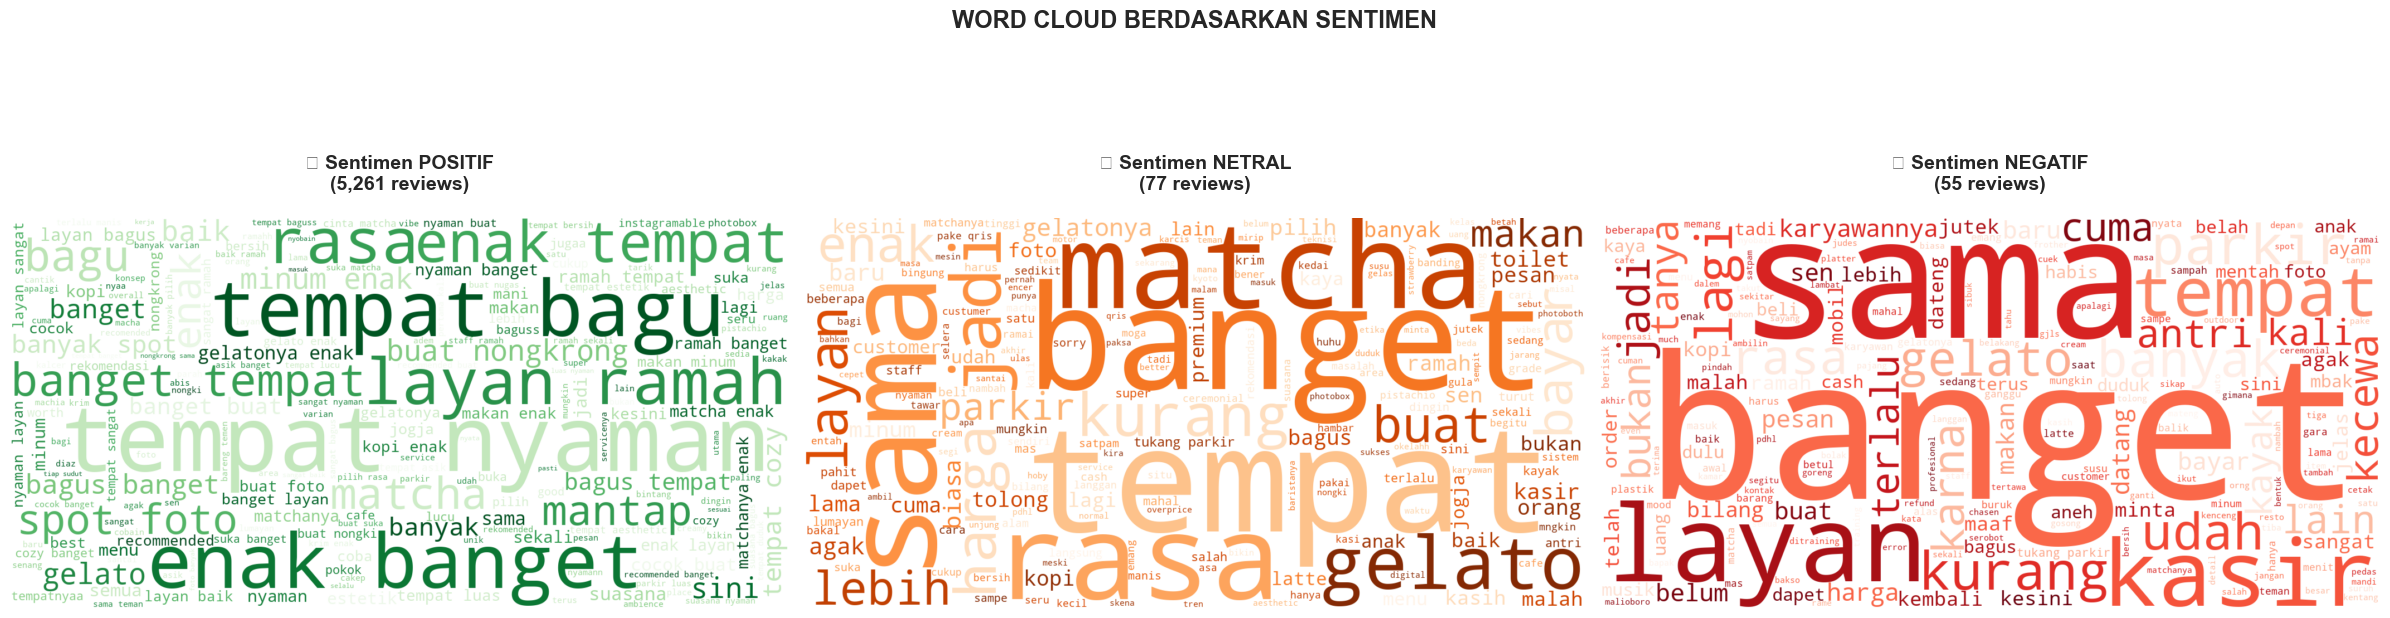

✓ WordCloud sentimen berhasil: 03_wordcloud_sentiment.png


In [17]:
# === CELL 8: WordCloud Analysis ===
print("\n" + "="*90)
print("☁️  CELL 8: WORDCLOUD ANALYSIS")
print("-"*90)

# WordCloud per Sentiment
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('WORD CLOUD BERDASARKAN SENTIMEN', fontsize=17, weight='bold', y=0.98)

sentiments = ['positif', 'netral', 'negatif']
colormaps = ['Greens', 'Oranges', 'Reds']

for idx, (sent, cmap) in enumerate(zip(sentiments, colormaps)):
    text = ' '.join(df_all[df_all['sentiment'] == sent]['ulasan_clean'].astype(str))
    
    if text.strip():
        wordcloud = WordCloud(width=1400, height=700,
                             background_color='white',
                             colormap=cmap,
                             max_words=200,
                             relative_scaling=0.5,
                             min_font_size=12,
                             contour_width=2,
                             contour_color='black').generate(text)
        
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        count = len(df_all[df_all['sentiment'] == sent])
        icon = '😊' if sent == 'positif' else '😐' if sent == 'netral' else '😞'
        axes[idx].set_title(f'{icon} Sentimen {sent.upper()}\n({count:,} reviews)',
                           fontsize=14, weight='bold', pad=20)
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'Insufficient Data', ha='center', va='center',
                      fontsize=16, transform=axes[idx].transAxes)
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('03_wordcloud_sentiment.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ WordCloud sentimen berhasil: 03_wordcloud_sentiment.png")


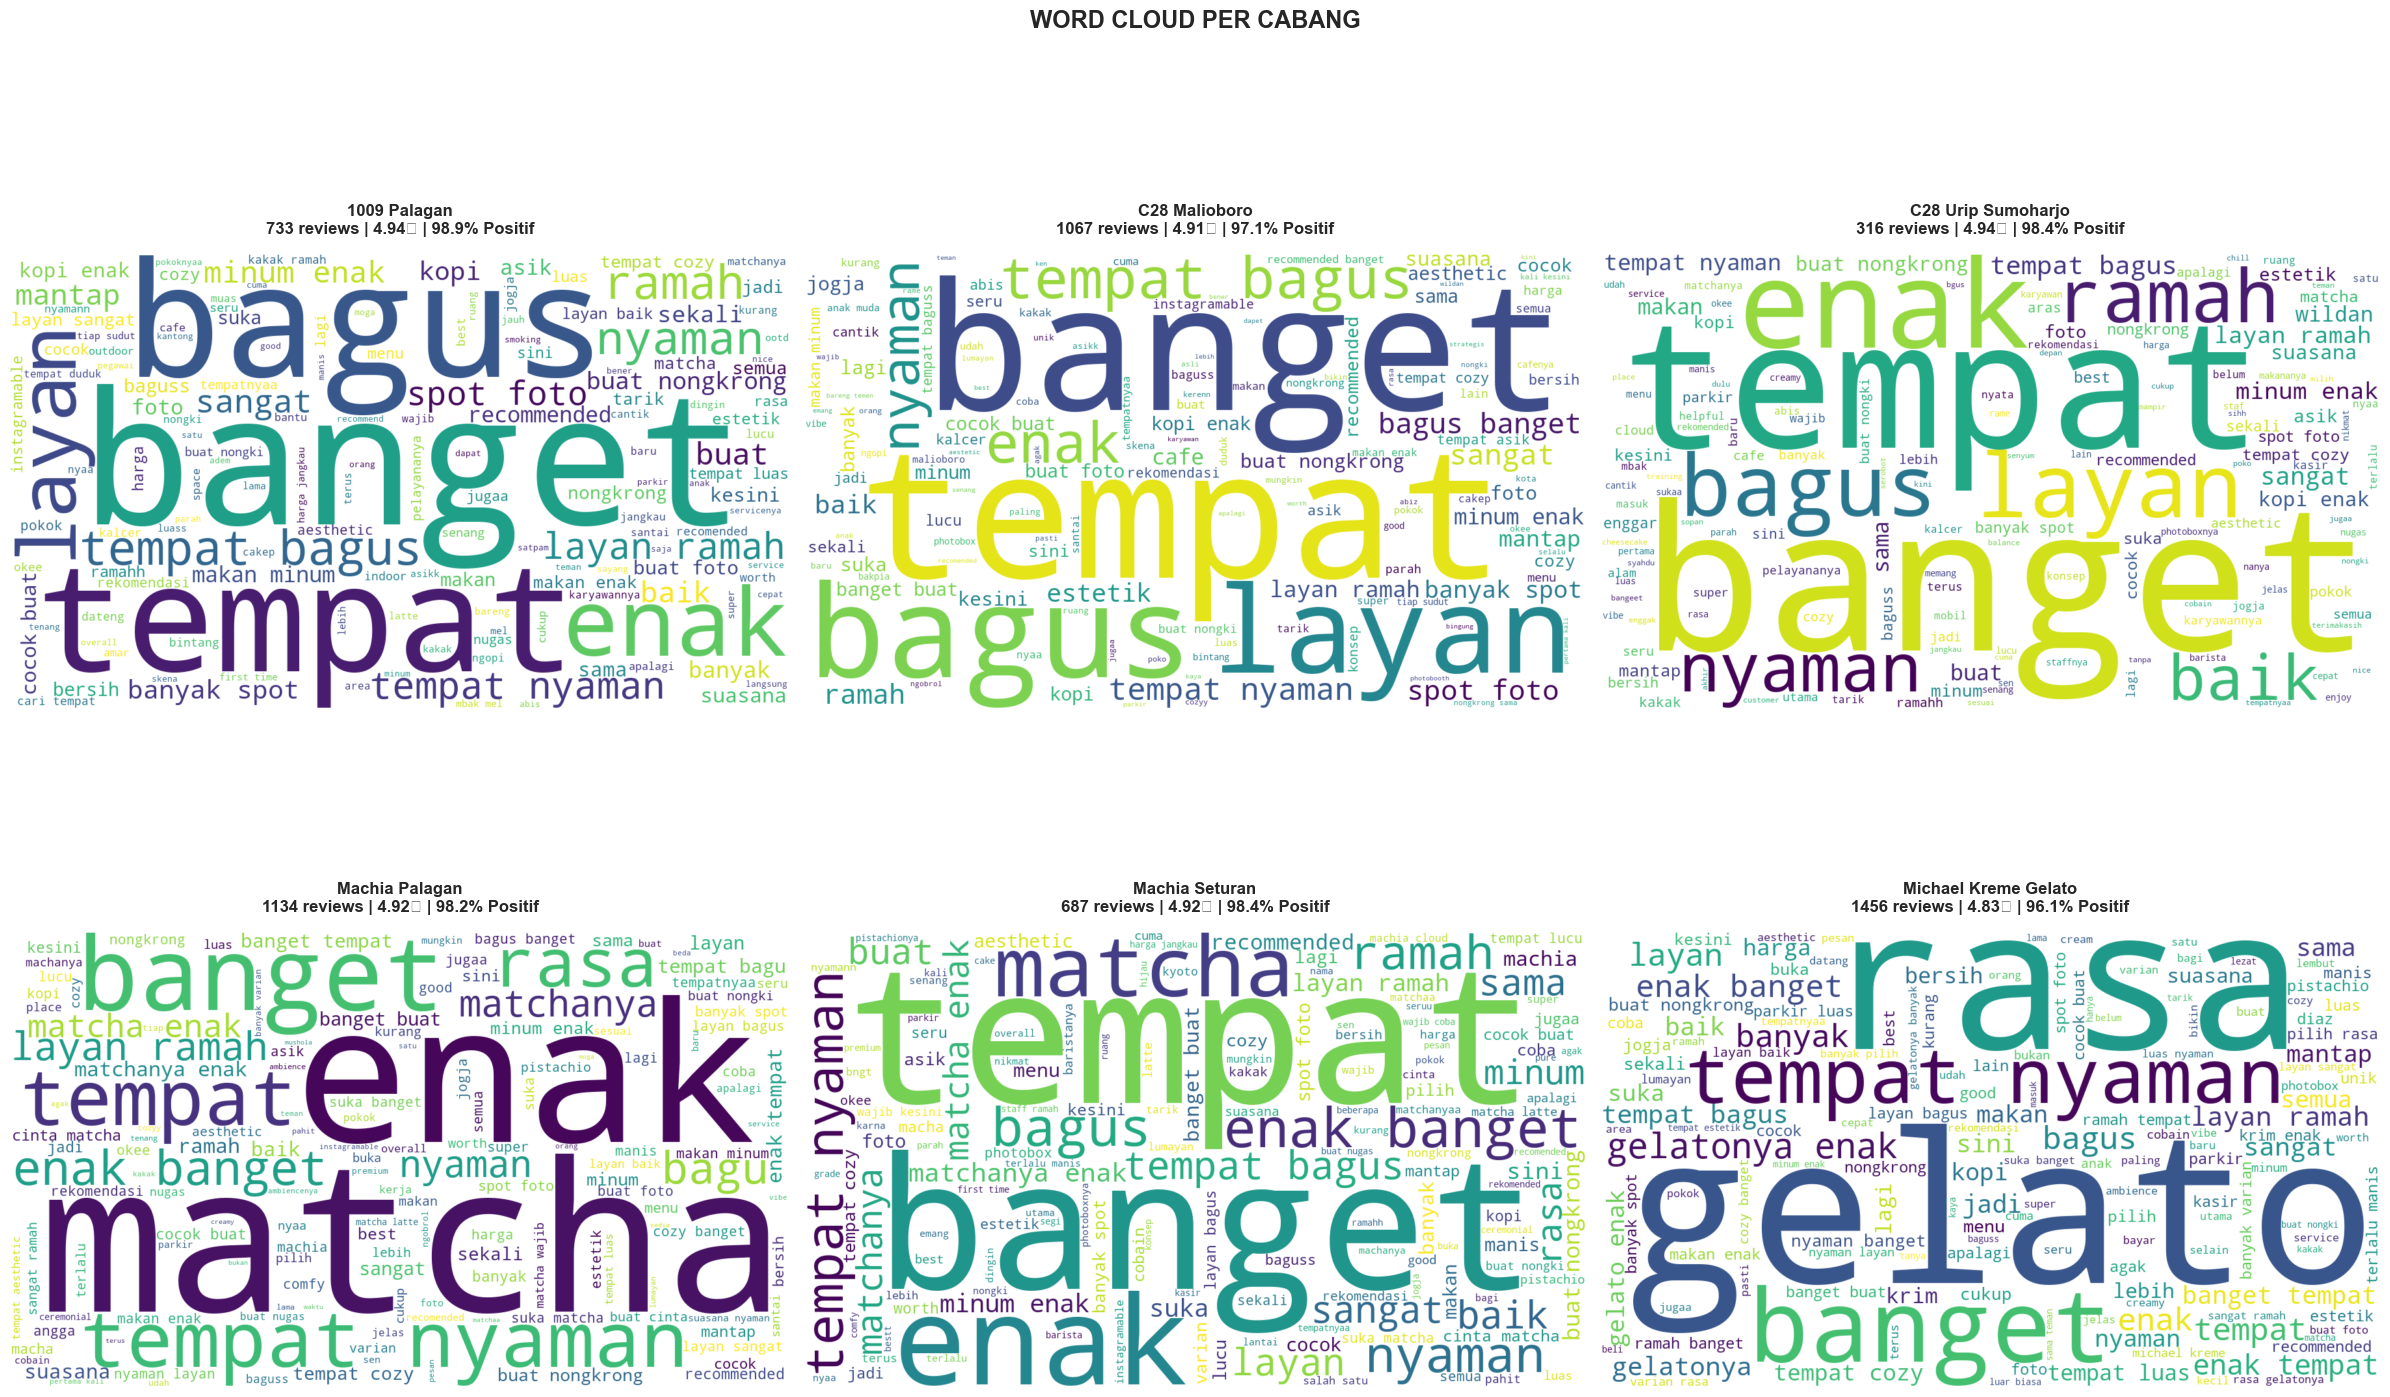

✓ WordCloud per cabang berhasil: 04_wordcloud_branches.png



In [18]:
# WordCloud per Branch (Top 3)
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
fig.suptitle('WORD CLOUD PER CABANG', fontsize=17, weight='bold', y=0.995)

for idx, (cabang, ax) in enumerate(zip(sorted(df_all['cabang'].unique()), axes.flatten())):
    text = ' '.join(df_all[df_all['cabang'] == cabang]['ulasan_clean'].astype(str))
    
    if text.strip():
        wordcloud = WordCloud(width=1200, height=700,
                             background_color='white',
                             colormap='viridis',
                             max_words=150,
                             relative_scaling=0.5,
                             min_font_size=10,
                             contour_width=2,
                             contour_color='darkblue').generate(text)
        
        total_reviews = len(df_all[df_all['cabang'] == cabang])
        avg_rating = df_all[df_all['cabang'] == cabang]['rating'].mean()
        pos_pct = (df_all[(df_all['cabang']==cabang) & (df_all['sentiment']=='positif')].shape[0] / total_reviews * 100)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'{cabang}\n{total_reviews} reviews | {avg_rating:.2f}★ | {pos_pct:.1f}% Positif',
                    fontsize=12, weight='bold', pad=15)
        ax.axis('off')

plt.tight_layout()
plt.savefig('04_wordcloud_branches.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ WordCloud per cabang berhasil: 04_wordcloud_branches.png")
print(f"{'='*90}\n")


📊 CELL 9: N-GRAM ANALYSIS (4-GRAMS)
------------------------------------------------------------------------------------------


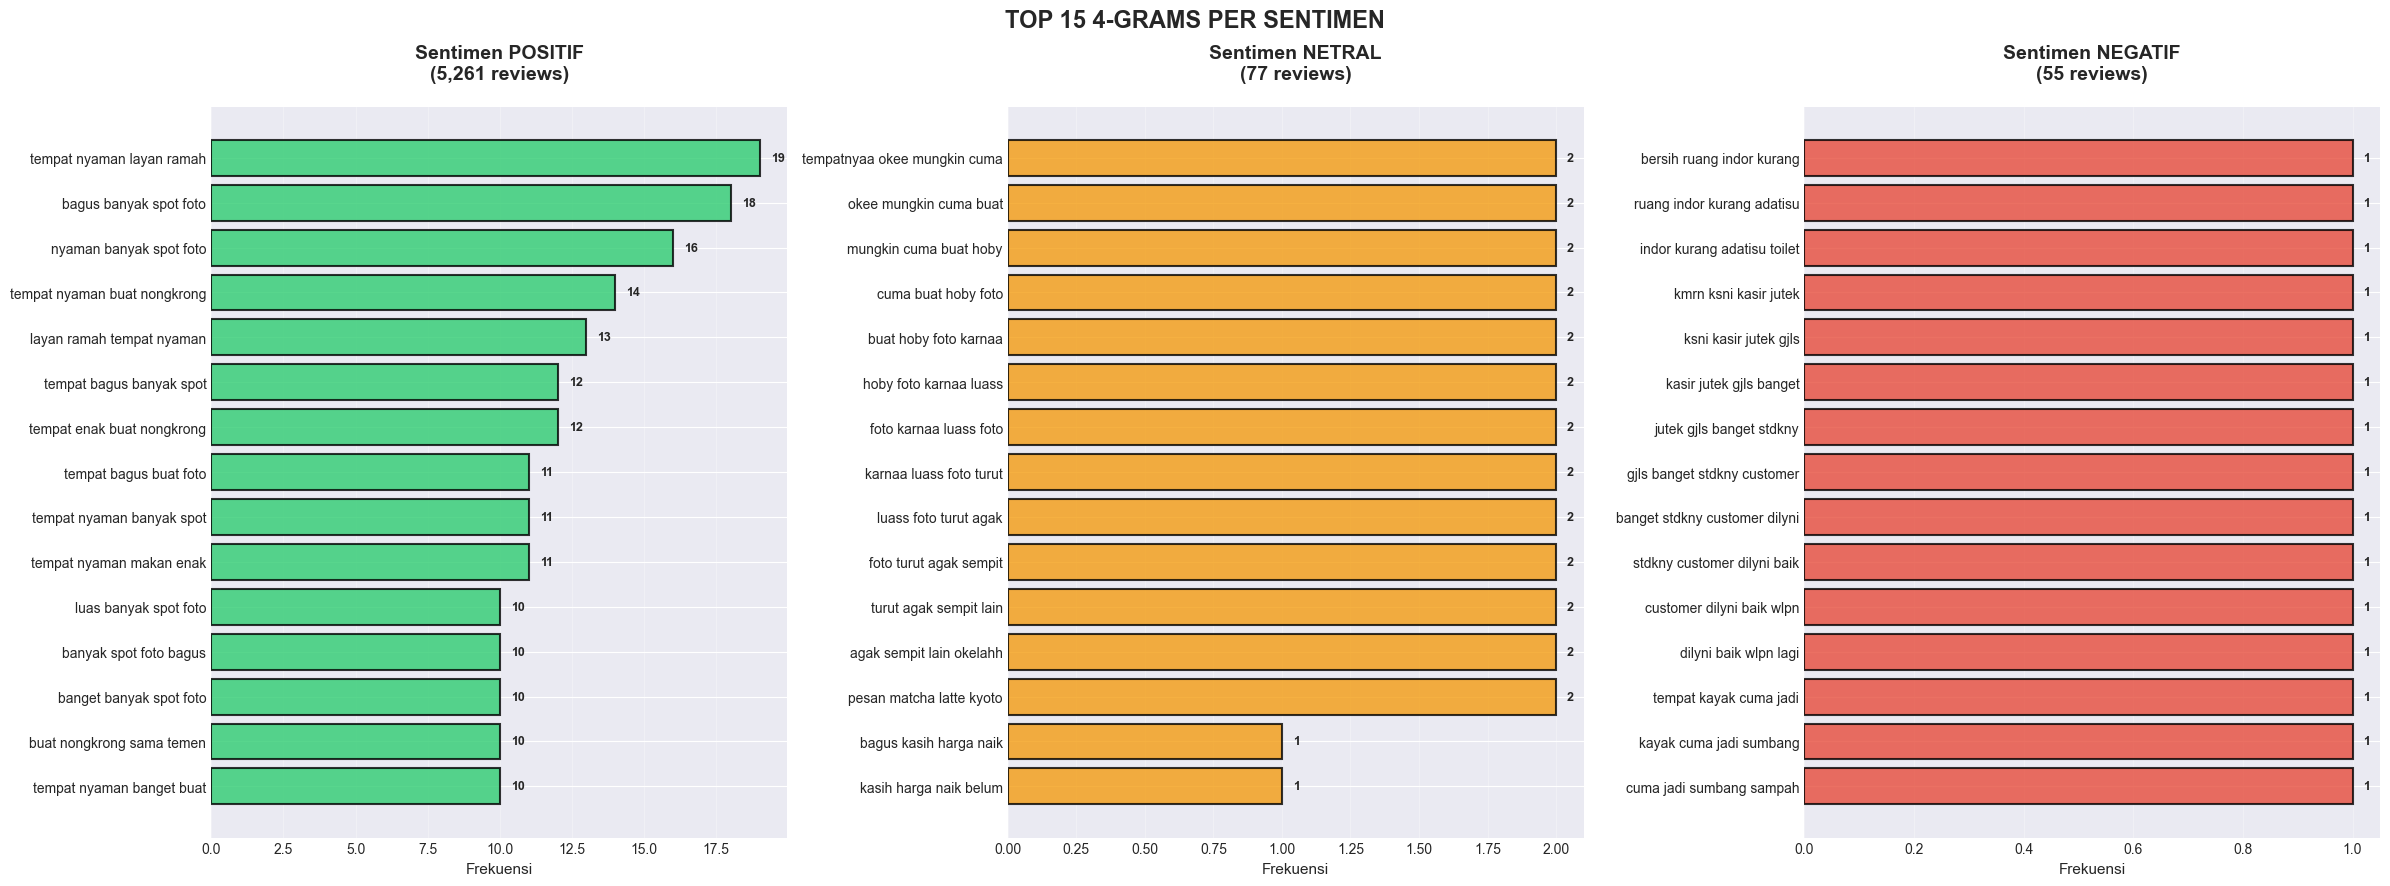

✓ N-gram analysis berhasil: 05_ngram_analysis.png



In [19]:
# === CELL 9: N-Gram Analysis ===
print("\n" + "="*90)
print("📊 CELL 9: N-GRAM ANALYSIS (4-GRAMS)")
print("-"*90)

def get_top_ngrams(corpus, n=4, top=15):
    """Extract top n-grams from corpus"""
    corpus_filtered = [text for text in corpus if len(text.split()) >= n]
    
    if len(corpus_filtered) == 0:
        return []
    
    try:
        vec = CountVectorizer(ngram_range=(n, n), max_features=3000).fit(corpus_filtered)
        bag_of_words = vec.transform(corpus_filtered)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:top]
    except:
        return []

# N-gram per Sentiment
fig, axes = plt.subplots(1, 3, figsize=(24, 9))
fig.suptitle('TOP 15 4-GRAMS PER SENTIMEN', fontsize=17, weight='bold', y=0.98)

for idx, sent in enumerate(['positif', 'netral', 'negatif']):
    corpus = df_all[df_all['sentiment'] == sent]['ulasan_clean'].dropna().tolist()
    
    if len(corpus) > 0:
        top_ngrams = get_top_ngrams(corpus, n=4, top=15)
        
        if top_ngrams:
            ngrams, counts = zip(*top_ngrams)
            ngrams_display = [ng[:45] + '...' if len(ng) > 45 else ng for ng in ngrams]
            
            bars = axes[idx].barh(range(len(ngrams_display)), counts, 
                                 color=colors_sentiment[sent], alpha=0.8, 
                                 edgecolor='black', linewidth=1.5)
            axes[idx].set_yticks(range(len(ngrams_display)))
            axes[idx].set_yticklabels(ngrams_display, fontsize=10)
            axes[idx].set_xlabel('Frekuensi', fontsize=11)
            axes[idx].set_title(f'Sentimen {sent.upper()}\n({len(corpus):,} reviews)',
                               fontsize=14, weight='bold', pad=20)
            axes[idx].invert_yaxis()
            axes[idx].grid(axis='x', alpha=0.3)
            
            for bar, count in zip(bars, counts):
                axes[idx].text(count + max(counts)*0.02, bar.get_y() + bar.get_height()/2,
                              f'{count}', va='center', fontsize=9, weight='bold')
        else:
            axes[idx].text(0.5, 0.5, 'Insufficient Data\n(Need more reviews)', 
                          ha='center', va='center', transform=axes[idx].transAxes, 
                          fontsize=14, weight='bold')
            axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'No Data', ha='center', va='center',
                      transform=axes[idx].transAxes, fontsize=14, weight='bold')
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('05_ngram_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ N-gram analysis berhasil: 05_ngram_analysis.png")
print(f"{'='*90}\n")


📊 CELL 10: TF-IDF ANALYSIS
------------------------------------------------------------------------------------------


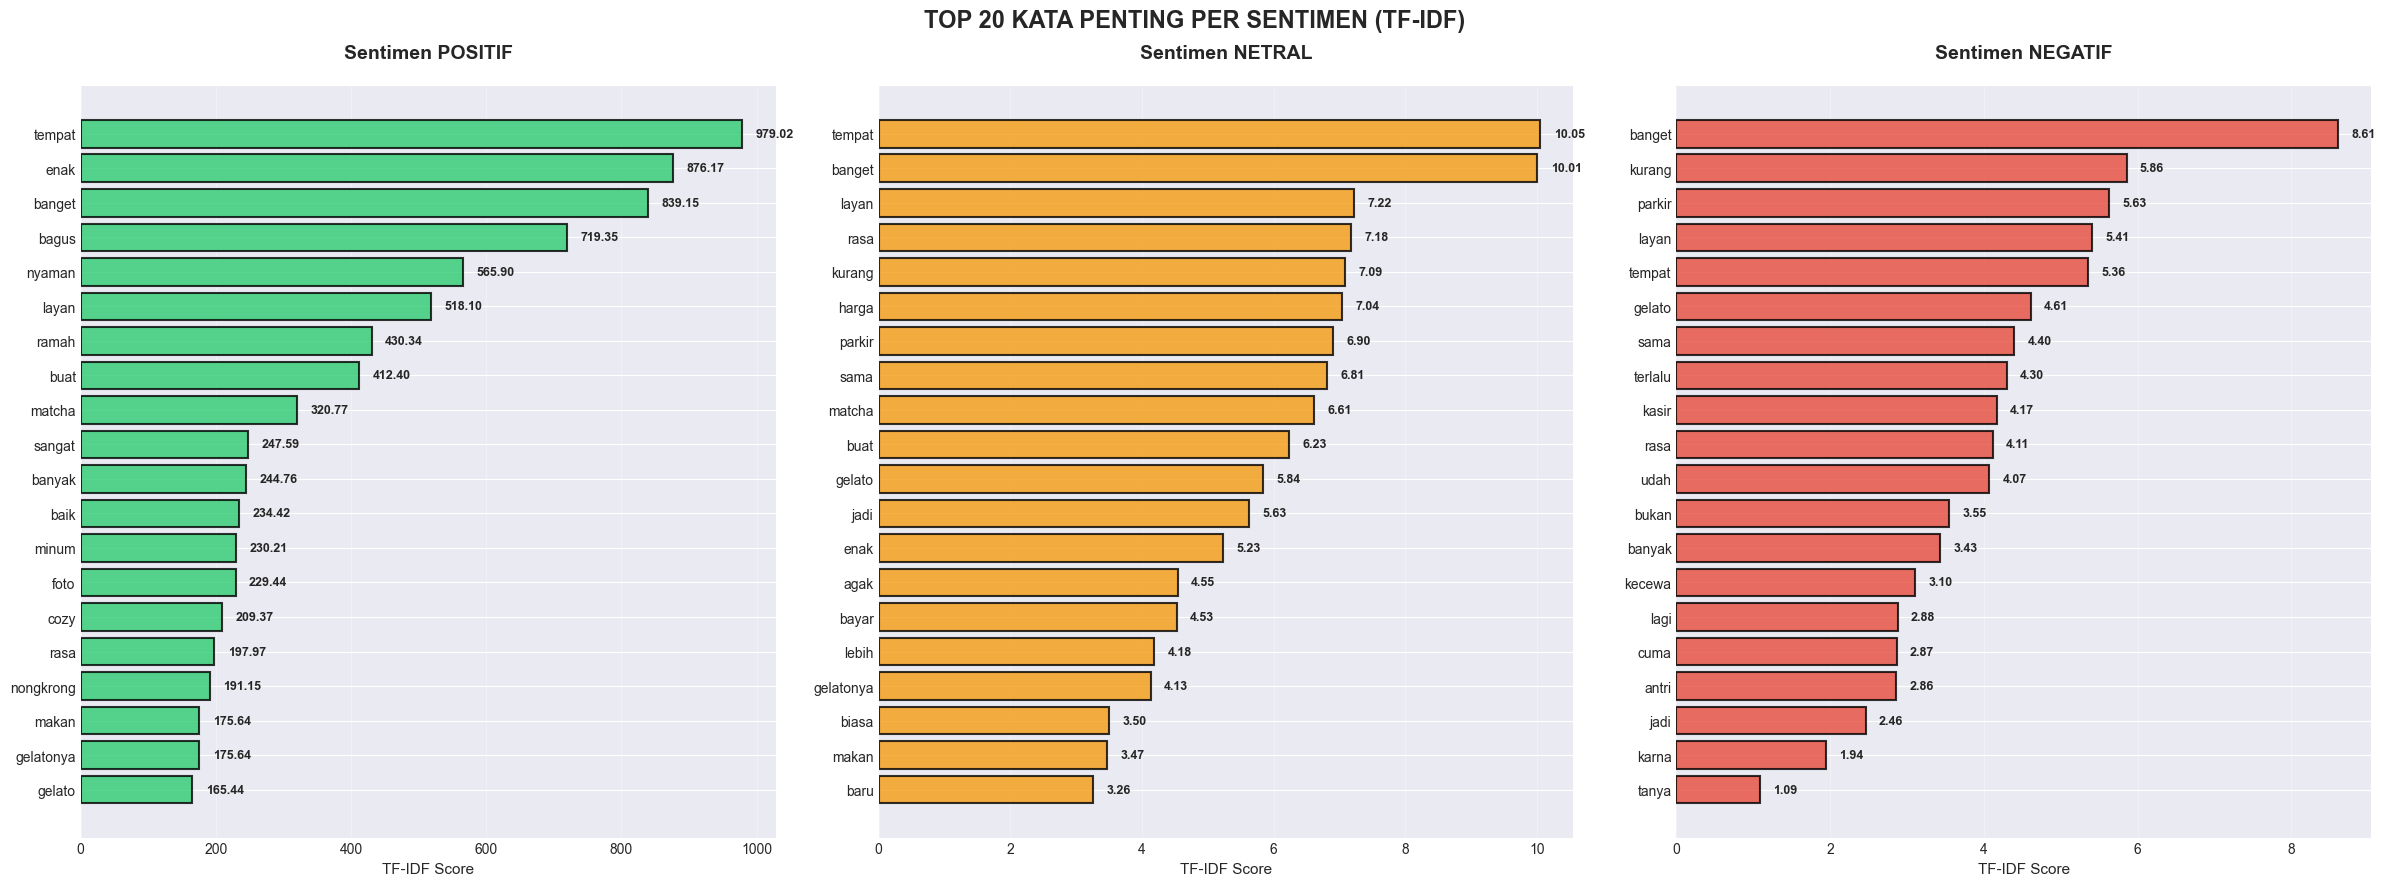

✓ TF-IDF analysis berhasil: 06_tfidf_analysis.png



In [20]:
# === CELL 10: TF-IDF Analysis ===
print("\n" + "="*90)
print("📊 CELL 10: TF-IDF ANALYSIS")
print("-"*90)

fig, axes = plt.subplots(1, 3, figsize=(24, 9))
fig.suptitle('TOP 20 KATA PENTING PER SENTIMEN (TF-IDF)', fontsize=17, weight='bold', y=0.98)

for idx, sent in enumerate(['positif', 'netral', 'negatif']):
    corpus = df_all[df_all['sentiment'] == sent]['ulasan_clean'].dropna().tolist()
    
    if len(corpus) > 0:
        try:
            tfidf = TfidfVectorizer(max_features=20, min_df=2, max_df=0.8)
            tfidf_matrix = tfidf.fit_transform(corpus)
            feature_names = tfidf.get_feature_names_out()
            tfidf_scores = tfidf_matrix.sum(axis=0).A1
            
            top_indices = tfidf_scores.argsort()[::-1][:20]
            top_words = [feature_names[i] for i in top_indices]
            top_scores = [tfidf_scores[i] for i in top_indices]
            
            bars = axes[idx].barh(range(len(top_words)), top_scores, 
                                 color=colors_sentiment[sent], alpha=0.8, 
                                 edgecolor='black', linewidth=1.5)
            axes[idx].set_yticks(range(len(top_words)))
            axes[idx].set_yticklabels(top_words, fontsize=10)
            axes[idx].set_xlabel('TF-IDF Score', fontsize=11)
            axes[idx].set_title(f'Sentimen {sent.upper()}', fontsize=14, weight='bold', pad=20)
            axes[idx].invert_yaxis()
            axes[idx].grid(axis='x', alpha=0.3)
            
            for bar, score in zip(bars, top_scores):
                axes[idx].text(score + max(top_scores)*0.02, bar.get_y() + bar.get_height()/2,
                              f'{score:.2f}', va='center', fontsize=9, weight='bold')
        except Exception as e:
            axes[idx].text(0.5, 0.5, f'Insufficient Data\n{str(e)[:50]}', 
                          ha='center', va='center', transform=axes[idx].transAxes, 
                          fontsize=12)
            axes[idx].axis('off')

plt.tight_layout()
plt.savefig('06_tfidf_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ TF-IDF analysis berhasil: 06_tfidf_analysis.png")
print(f"{'='*90}\n")


📊 CELL 11: CORRELATION & HEATMAP ANALYSIS
------------------------------------------------------------------------------------------


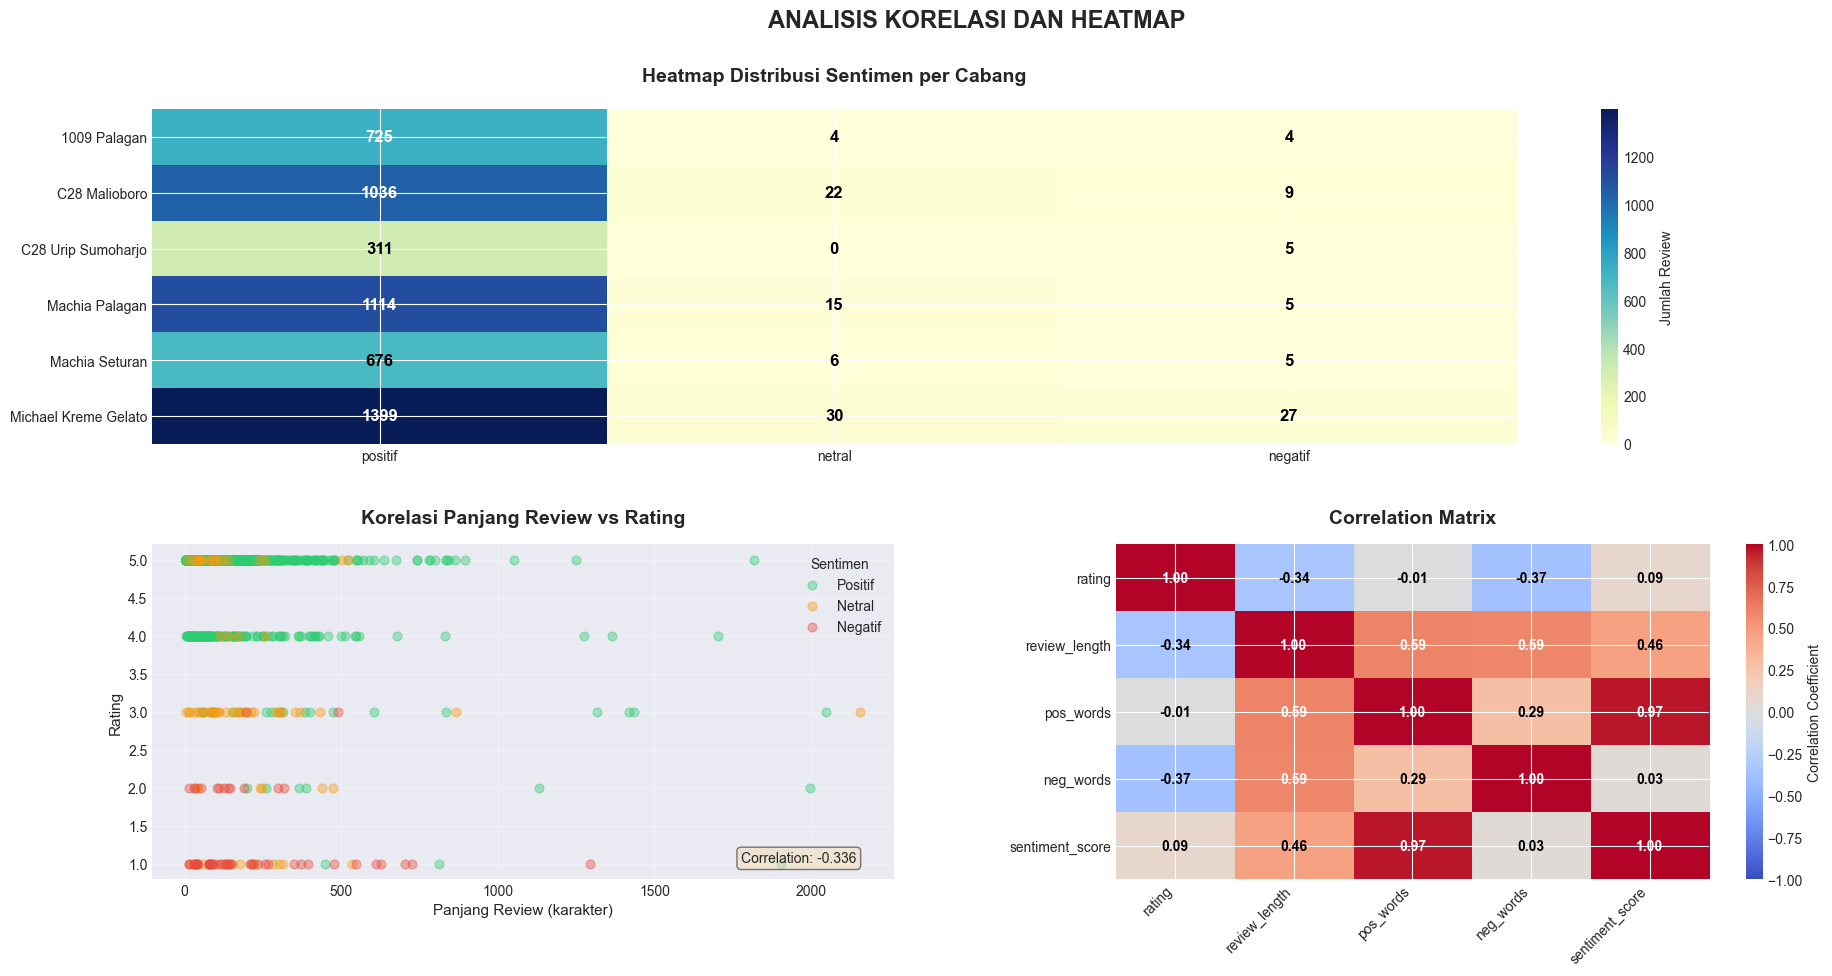

✓ Correlation & heatmap analysis berhasil: 07_correlation_heatmap.png



In [21]:
# === CELL 11: Correlation & Heatmap ===
print("\n" + "="*90)
print("📊 CELL 11: CORRELATION & HEATMAP ANALYSIS")
print("-"*90)

fig = plt.figure(figsize=(22, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 11.1 Heatmap: Sentiment Count by Branch
ax1 = fig.add_subplot(gs[0, :])
pivot_data = df_all.groupby(['cabang', 'sentiment']).size().unstack(fill_value=0)
pivot_data = pivot_data[['positif', 'netral', 'negatif']]

im = ax1.imshow(pivot_data.values, cmap='YlGnBu', aspect='auto')
ax1.set_xticks(np.arange(len(pivot_data.columns)))
ax1.set_yticks(np.arange(len(pivot_data.index)))
ax1.set_xticklabels(pivot_data.columns)
ax1.set_yticklabels(pivot_data.index)

for i in range(len(pivot_data.index)):
    for j in range(len(pivot_data.columns)):
        text = ax1.text(j, i, pivot_data.values[i, j],
                       ha="center", va="center", color="black" if pivot_data.values[i, j] < pivot_data.values.max()/2 else "white",
                       fontsize=12, weight='bold')

ax1.set_title('Heatmap Distribusi Sentimen per Cabang', fontsize=14, weight='bold', pad=20)
cbar = plt.colorbar(im, ax=ax1, label='Jumlah Review')

# 11.2 Scatter: Rating vs Review Length
ax2 = fig.add_subplot(gs[1, 0])
for sent in ['positif', 'netral', 'negatif']:
    data = df_all[df_all['sentiment'] == sent]
    ax2.scatter(data['review_length'], data['rating'],
               alpha=0.4, s=40, label=sent.capitalize(), color=colors_sentiment[sent])

ax2.set_title('Korelasi Panjang Review vs Rating', fontsize=14, weight='bold', pad=15)
ax2.set_xlabel('Panjang Review (karakter)', fontsize=11)
ax2.set_ylabel('Rating', fontsize=11)
ax2.legend(title='Sentimen', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add correlation coefficient
from scipy.stats import pearsonr
corr, _ = pearsonr(df_all['review_length'], df_all['rating'])
ax2.text(0.95, 0.05, f'Correlation: {corr:.3f}', transform=ax2.transAxes,
         fontsize=10, ha='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 11.3 Heatmap: Correlation Matrix
ax3 = fig.add_subplot(gs[1, 1])
correlation_data = df_all[['rating', 'review_length', 'pos_words', 'neg_words', 'sentiment_score']].corr()
im = ax3.imshow(correlation_data.values, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

ax3.set_xticks(np.arange(len(correlation_data.columns)))
ax3.set_yticks(np.arange(len(correlation_data.index)))
ax3.set_xticklabels(correlation_data.columns, rotation=45, ha='right')
ax3.set_yticklabels(correlation_data.index)

for i in range(len(correlation_data.index)):
    for j in range(len(correlation_data.columns)):
        text = ax3.text(j, i, f'{correlation_data.values[i, j]:.2f}',
                       ha="center", va="center", 
                       color="white" if abs(correlation_data.values[i, j]) > 0.5 else "black",
                       fontsize=10, weight='bold')

ax3.set_title('Correlation Matrix', fontsize=14, weight='bold', pad=15)
plt.colorbar(im, ax=ax3, label='Correlation Coefficient')

plt.suptitle('ANALISIS KORELASI DAN HEATMAP', fontsize=17, weight='bold', y=0.98)
plt.savefig('07_correlation_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Correlation & heatmap analysis berhasil: 07_correlation_heatmap.png")
print(f"{'='*90}\n")


📊 CELL 12: COMPARATIVE METRICS
------------------------------------------------------------------------------------------


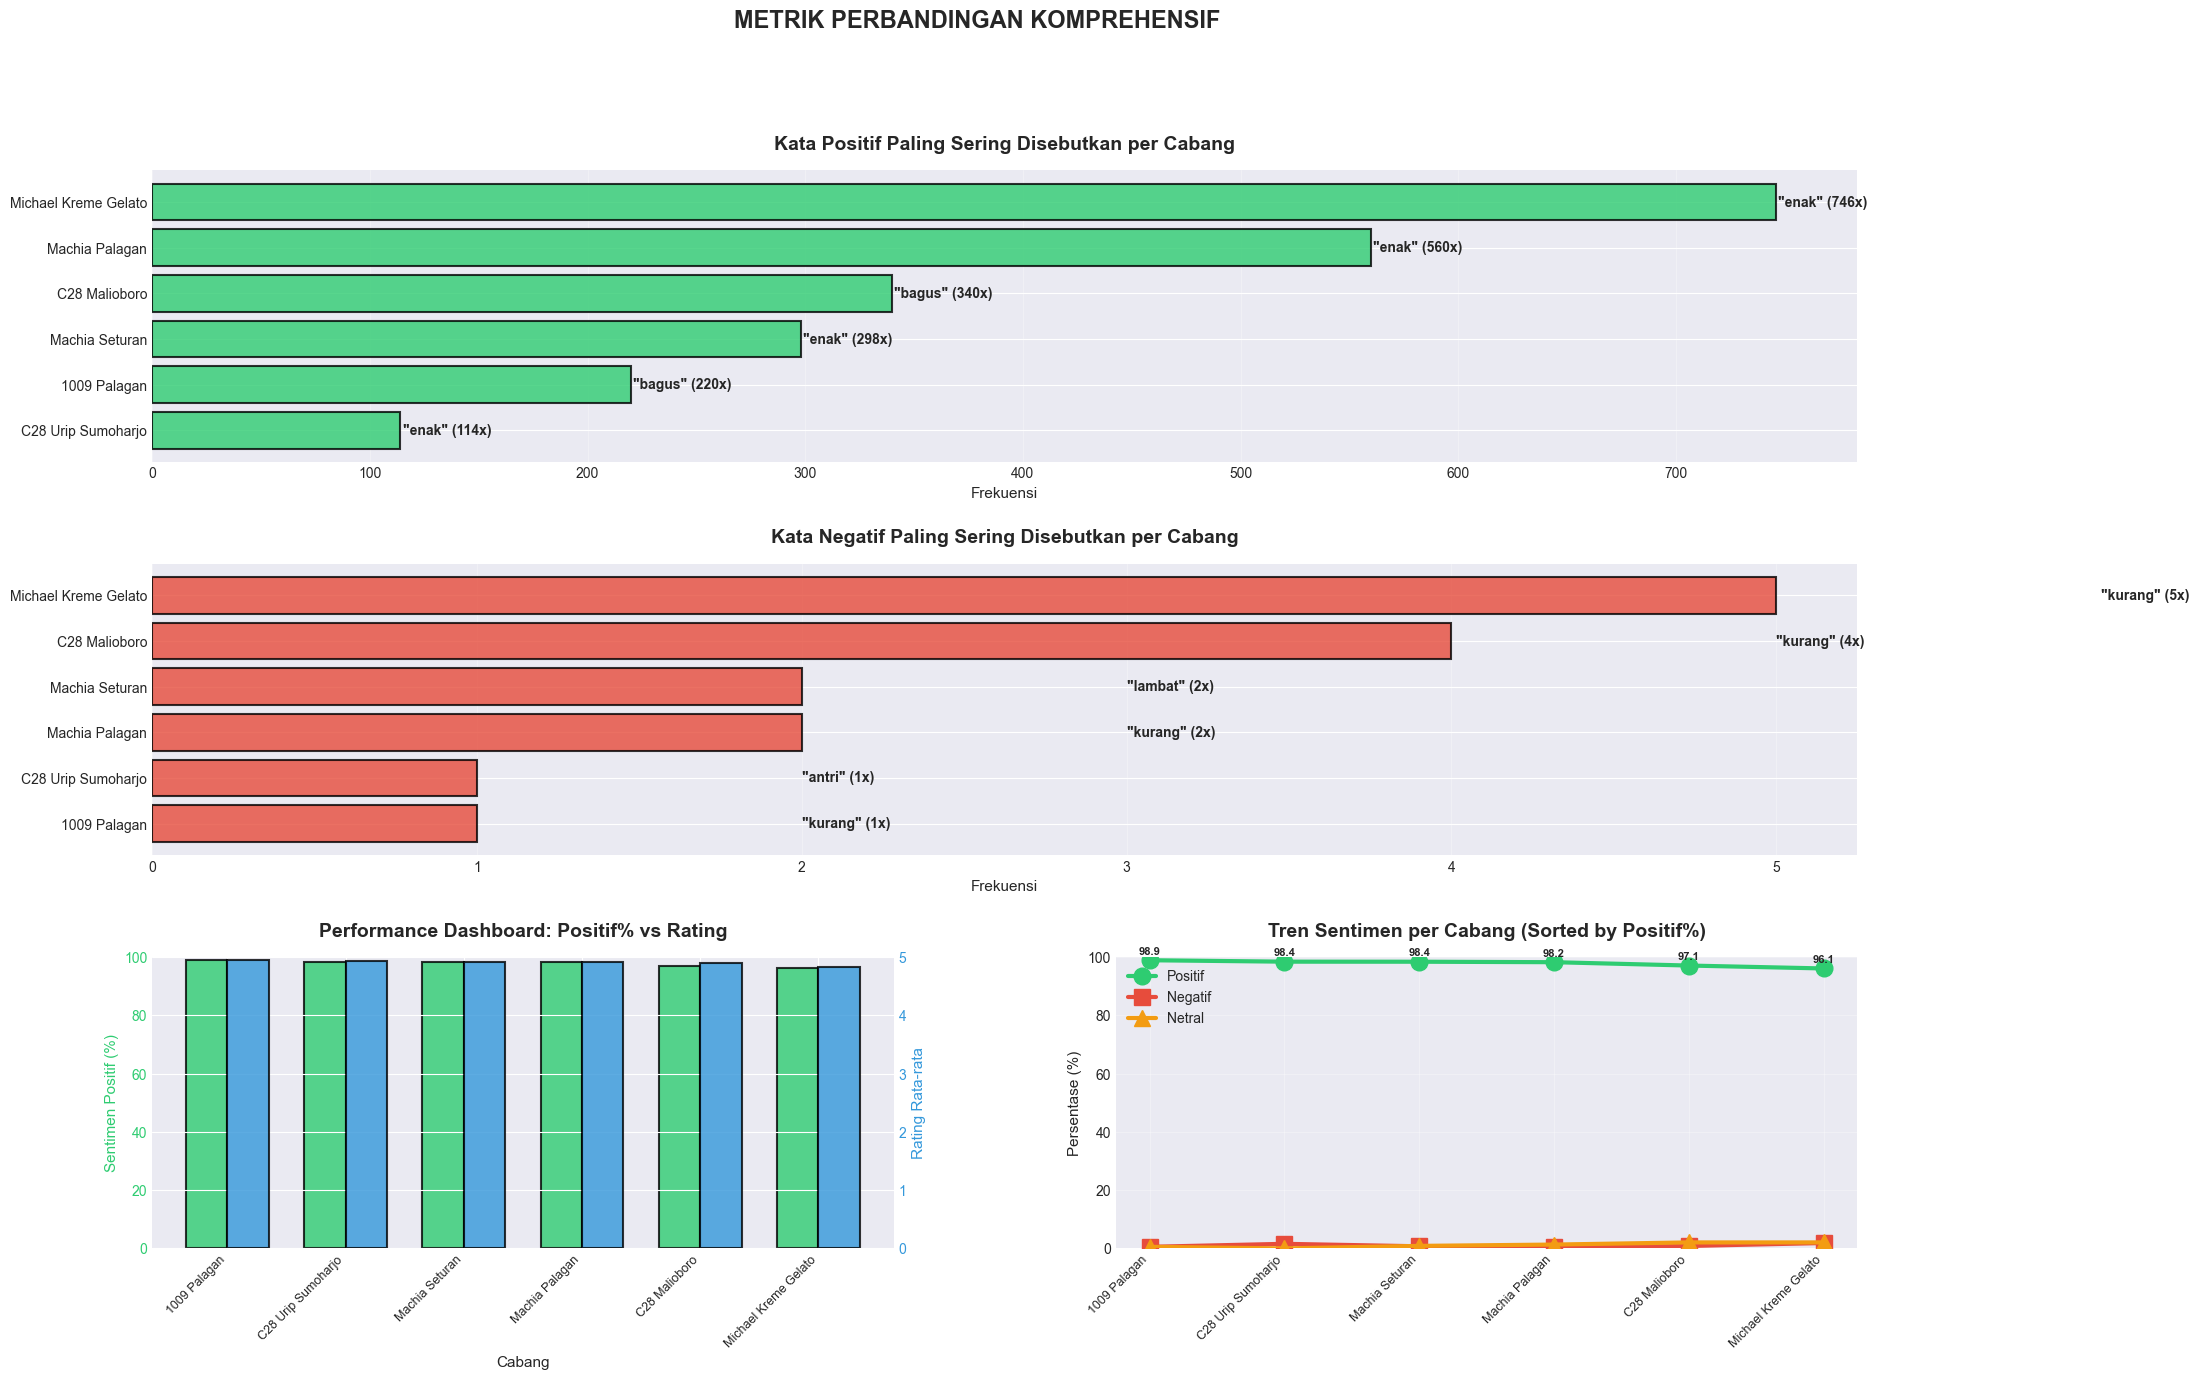

✓ Comparative metrics berhasil: 08_comparative_metrics.png



In [22]:
# === CELL 12: Comparative Metrics ===
print("\n" + "="*90)
print("📊 CELL 12: COMPARATIVE METRICS")
print("-"*90)

fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# 12.1 Top Positive Words per Branch
ax1 = fig.add_subplot(gs[0, :])
pos_phrases = []
for cabang in df_all['cabang'].unique():
    text = ' '.join(df_all[(df_all['cabang']==cabang) & (df_all['sentiment']=='positif')]['ulasan_clean'])
    words = [w for w in text.split() if w in positive_words]
    if words:
        top_word = Counter(words).most_common(1)[0]
        pos_phrases.append({'Cabang': cabang, 'Kata': top_word[0], 'Frekuensi': top_word[1]})

if pos_phrases:
    df_pos = pd.DataFrame(pos_phrases).sort_values('Frekuensi', ascending=True)
    bars = ax1.barh(df_pos['Cabang'], df_pos['Frekuensi'], color='#2ecc71', alpha=0.8, 
                    edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Frekuensi', fontsize=11)
    ax1.set_title('Kata Positif Paling Sering Disebutkan per Cabang', fontsize=14, weight='bold', pad=15)
    ax1.grid(axis='x', alpha=0.3)
    
    for i, (bar, kata, freq) in enumerate(zip(bars, df_pos['Kata'], df_pos['Frekuensi'])):
        ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'"{kata}" ({freq}x)', va='center', fontsize=10, weight='bold')

# 12.2 Top Negative Words per Branch
ax2 = fig.add_subplot(gs[1, :])
neg_phrases = []
for cabang in df_all['cabang'].unique():
    text = ' '.join(df_all[(df_all['cabang']==cabang) & (df_all['sentiment']=='negatif')]['ulasan_clean'])
    words = [w for w in text.split() if w in negative_words]
    if words:
        top_word = Counter(words).most_common(1)[0]
        neg_phrases.append({'Cabang': cabang, 'Kata': top_word[0], 'Frekuensi': top_word[1]})

if neg_phrases:
    df_neg = pd.DataFrame(neg_phrases).sort_values('Frekuensi', ascending=True)
    bars = ax2.barh(df_neg['Cabang'], df_neg['Frekuensi'], color='#e74c3c', alpha=0.8,
                    edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Frekuensi', fontsize=11)
    ax2.set_title('Kata Negatif Paling Sering Disebutkan per Cabang', fontsize=14, weight='bold', pad=15)
    ax2.grid(axis='x', alpha=0.3)
    
    for i, (bar, kata, freq) in enumerate(zip(bars, df_neg['Kata'], df_neg['Frekuensi'])):
        ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'"{kata}" ({freq}x)', va='center', fontsize=10, weight='bold')

# 12.3 Performance Dashboard
ax3 = fig.add_subplot(gs[2, 0])
branch_performance = pd.DataFrame({
    'Cabang': sentiment_pct_branch.index,
    'Positif%': sentiment_pct_branch['positif'].values,
    'Rating': [df_all[df_all['cabang']==c]['rating'].mean() for c in sentiment_pct_branch.index],
    'Total': sentiment_by_branch.sum(axis=1).values
})
branch_performance = branch_performance.sort_values('Positif%', ascending=False)

x = np.arange(len(branch_performance))
width = 0.35

bars1 = ax3.bar(x - width/2, branch_performance['Positif%'], width, 
                label='Positif %', color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
ax3_twin = ax3.twinx()
bars2 = ax3_twin.bar(x + width/2, branch_performance['Rating'], width,
                     label='Avg Rating', color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_xlabel('Cabang', fontsize=11)
ax3.set_ylabel('Sentimen Positif (%)', fontsize=11, color='#2ecc71')
ax3_twin.set_ylabel('Rating Rata-rata', fontsize=11, color='#3498db')
ax3.set_title('Performance Dashboard: Positif% vs Rating', fontsize=14, weight='bold', pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(branch_performance['Cabang'], rotation=45, ha='right', fontsize=9)
ax3.tick_params(axis='y', labelcolor='#2ecc71')
ax3_twin.tick_params(axis='y', labelcolor='#3498db')
ax3_twin.set_ylim(0, 5)
ax3.set_ylim(0, 100)
ax3.grid(axis='y', alpha=0.3)

# 12.4 Sentiment Trend Line
ax4 = fig.add_subplot(gs[2, 1])
sentiment_pct_sorted = sentiment_pct_branch.sort_values('positif', ascending=False)
x_pos = np.arange(len(sentiment_pct_sorted))

ax4.plot(x_pos, sentiment_pct_sorted['positif'], marker='o', linewidth=3, 
         markersize=12, label='Positif', color='#2ecc71')
ax4.plot(x_pos, sentiment_pct_sorted['negatif'], marker='s', linewidth=3, 
         markersize=12, label='Negatif', color='#e74c3c')
ax4.plot(x_pos, sentiment_pct_sorted['netral'], marker='^', linewidth=3, 
         markersize=12, label='Netral', color='#f39c12')

ax4.set_xticks(x_pos)
ax4.set_xticklabels(sentiment_pct_sorted.index, rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Persentase (%)', fontsize=11)
ax4.set_title('Tren Sentimen per Cabang (Sorted by Positif%)', fontsize=14, weight='bold', pad=15)
ax4.legend(fontsize=10, loc='best')
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 100)

# Add value labels
for i, row in sentiment_pct_sorted.iterrows():
    ax4.text(x_pos[sentiment_pct_sorted.index.get_loc(i)], row['positif'] + 2, 
             f"{row['positif']:.1f}", ha='center', fontsize=8, weight='bold')

plt.suptitle('METRIK PERBANDINGAN KOMPREHENSIF', fontsize=17, weight='bold', y=0.995)
plt.savefig('08_comparative_metrics.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Comparative metrics berhasil: 08_comparative_metrics.png")
print(f"{'='*90}\n")


In [23]:
# ===================================================================
# BAGIAN 5: SUMMARY REPORT & STATISTICS
# ===================================================================
print("\n" + "="*90)
print("📋 CELL 13: SUMMARY REPORT & COMPREHENSIVE STATISTICS")
print("="*90)

print("\n" + "┏" + "━"*88 + "┓")
print("┃" + " "*25 + "📊 RINGKASAN ANALISIS SENTIMEN" + " "*32 + "┃")
print("┃" + " "*30 + "CAFE C28 GROUP" + " "*43 + "┃")
print("┗" + "━"*88 + "┛\n")


📋 CELL 13: SUMMARY REPORT & COMPREHENSIVE STATISTICS

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                         📊 RINGKASAN ANALISIS SENTIMEN                                ┃
┃                              CAFE C28 GROUP                                           ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛



In [24]:
# 1. DATA OVERVIEW
print("1️⃣  DATA OVERVIEW")
print("─" * 90)
print(f"   Total Reviews Analyzed      : {len(df_all):,}")
print(f"   Total Branches              : {df_all['cabang'].nunique()}")
print(f"   Average Review Length       : {df_all['review_length'].mean():.0f} characters")
print(f"   Date Range                  : {df_all['tanggal'].min() if 'tanggal' in df_all.columns else 'N/A'} - {df_all['tanggal'].max() if 'tanggal' in df_all.columns else 'N/A'}")

1️⃣  DATA OVERVIEW
──────────────────────────────────────────────────────────────────────────────────────────
   Total Reviews Analyzed      : 5,393
   Total Branches              : 6
   Average Review Length       : 71 characters
   Date Range                  : 1 hari lalu - seminggu lalu


In [25]:
# 2. SENTIMENT DISTRIBUTION
print("\n2️⃣  SENTIMENT DISTRIBUTION")
print("─" * 90)
for sent in ['positif', 'netral', 'negatif']:
    count = (df_all['sentiment'] == sent).sum()
    pct = count / len(df_all) * 100
    bar = '█' * int(pct)
    icon = '😊' if sent == 'positif' else '😐' if sent == 'netral' else '😞'
    print(f"   {icon} {sent.capitalize():12s}: {bar:50s} {count:5,} ({pct:5.2f}%)")


2️⃣  SENTIMENT DISTRIBUTION
──────────────────────────────────────────────────────────────────────────────────────────
   😊 Positif     : █████████████████████████████████████████████████████████████████████████████████████████████████ 5,261 (97.55%)
   😐 Netral      : █                                                     77 ( 1.43%)
   😞 Negatif     : █                                                     55 ( 1.02%)


In [26]:
# 3. RATING STATISTICS
print("\n3️⃣  RATING STATISTICS")
print("─" * 90)
print(f"   Overall Average Rating      : {df_all['rating'].mean():.2f}★")
print(f"   Median Rating               : {df_all['rating'].median():.1f}★")
print(f"   Standard Deviation          : {df_all['rating'].std():.3f}")
print(f"   Mode Rating                 : {df_all['rating'].mode()[0]:.0f}★")
print(f"   Rating Range                : {df_all['rating'].min():.0f}★ - {df_all['rating'].max():.0f}★")


3️⃣  RATING STATISTICS
──────────────────────────────────────────────────────────────────────────────────────────
   Overall Average Rating      : 4.90★
   Median Rating               : 5.0★
   Standard Deviation          : 0.518
   Mode Rating                 : 5★
   Rating Range                : 1★ - 5★


In [27]:
# 4. TOP PERFORMING BRANCHES
print("\n4️⃣  TOP 3 PERFORMING BRANCHES (by Positive Sentiment %)")
print("─" * 90)
top3_pos = sentiment_pct_branch['positif'].sort_values(ascending=False).head(3)
for i, (branch, pct) in enumerate(top3_pos.items(), 1):
    total = sentiment_by_branch.loc[branch].sum()
    avg_rating = df_all[df_all['cabang']==branch]['rating'].mean()
    medal = '🥇' if i == 1 else '🥈' if i == 2 else '🥉'
    print(f"   {medal} {i}. {branch:30s}")
    print(f"      └─ Sentimen Positif: {pct:5.2f}% | Total Reviews: {total:4,} | Avg Rating: {avg_rating:.2f}★")


4️⃣  TOP 3 PERFORMING BRANCHES (by Positive Sentiment %)
──────────────────────────────────────────────────────────────────────────────────────────
   🥇 1. 1009 Palagan                  
      └─ Sentimen Positif: 98.91% | Total Reviews:  733 | Avg Rating: 4.94★
   🥈 2. C28 Urip Sumoharjo            
      └─ Sentimen Positif: 98.42% | Total Reviews:  316 | Avg Rating: 4.94★
   🥉 3. Machia Seturan                
      └─ Sentimen Positif: 98.40% | Total Reviews:  687 | Avg Rating: 4.92★


In [28]:
# 5. BRANCHES NEEDING ATTENTION
print("\n5️⃣  TOP 3 BRANCHES NEEDING ATTENTION (by Negative Sentiment %)")
print("─" * 90)
top3_neg = sentiment_pct_branch['negatif'].sort_values(ascending=False).head(3)
for i, (branch, pct) in enumerate(top3_neg.items(), 1):
    total = sentiment_by_branch.loc[branch].sum()
    avg_rating = df_all[df_all['cabang']==branch]['rating'].mean()
    print(f"   ⚠️  {i}. {branch:30s}")
    print(f"      └─ Sentimen Negatif: {pct:5.2f}% | Total Reviews: {total:4,} | Avg Rating: {avg_rating:.2f}★")


5️⃣  TOP 3 BRANCHES NEEDING ATTENTION (by Negative Sentiment %)
──────────────────────────────────────────────────────────────────────────────────────────
   ⚠️  1. Michael Kreme Gelato          
      └─ Sentimen Negatif:  1.85% | Total Reviews: 1,456 | Avg Rating: 4.83★
   ⚠️  2. C28 Urip Sumoharjo            
      └─ Sentimen Negatif:  1.58% | Total Reviews:  316 | Avg Rating: 4.94★
   ⚠️  3. C28 Malioboro                 
      └─ Sentimen Negatif:  0.84% | Total Reviews: 1,067 | Avg Rating: 4.91★


In [29]:
# 6. SENTIMENT BY BRANCH TABLE
print("\n6️⃣  DETAILED SENTIMENT BREAKDOWN PER BRANCH")
print("─" * 90)
detailed_table = sentiment_pct_branch.copy()
detailed_table['Total'] = sentiment_by_branch.sum(axis=1)
detailed_table['Avg_Rating'] = [df_all[df_all['cabang']==c]['rating'].mean() for c in detailed_table.index]
detailed_table = detailed_table[['Total', 'Avg_Rating', 'positif', 'netral', 'negatif']]
detailed_table.columns = ['Total_Reviews', 'Avg_Rating', 'Positif_%', 'Netral_%', 'Negatif_%']
detailed_table = detailed_table.round(2)
print(detailed_table.to_string())


6️⃣  DETAILED SENTIMENT BREAKDOWN PER BRANCH
──────────────────────────────────────────────────────────────────────────────────────────
                      Total_Reviews  Avg_Rating  Positif_%  Netral_%  Negatif_%
cabang                                                                         
1009 Palagan                    733        4.94      98.91      0.55       0.55
C28 Malioboro                  1067        4.91      97.09      2.06       0.84
C28 Urip Sumoharjo              316        4.94      98.42      0.00       1.58
Machia Palagan                 1134        4.92      98.24      1.32       0.44
Machia Seturan                  687        4.92      98.40      0.87       0.73
Michael Kreme Gelato           1456        4.83      96.09      2.06       1.85


In [30]:
# 7. TOP KEYWORDS
print("\n7️⃣  TOP 10 POSITIVE KEYWORDS (Overall)")
print("─" * 90)
all_positive_text = ' '.join(df_all[df_all['sentiment']=='positif']['ulasan_clean'])
pos_words = [w for w in all_positive_text.split() if w in positive_words]
if pos_words:
    for i, (word, count) in enumerate(Counter(pos_words).most_common(10), 1):
        bar = '▓' * int(count / Counter(pos_words).most_common(1)[0][1] * 30)
        print(f"   {i:2d}. {word:20s}: {bar:30s} {count:4,} mentions")


7️⃣  TOP 10 POSITIVE KEYWORDS (Overall)
──────────────────────────────────────────────────────────────────────────────────────────
    1. enak                : ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓ 2,097 mentions
    2. bagus               : ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓             1,266 mentions
    3. nyaman              : ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓                1,094 mentions
    4. ramah               : ▓▓▓▓▓▓▓▓▓▓▓▓                    892 mentions
    5. baik                : ▓▓▓▓▓                           378 mentions
    6. cozy                : ▓▓▓▓                            339 mentions
    7. suka                : ▓▓▓▓                            290 mentions
    8. cocok               : ▓▓▓▓                            288 mentions
    9. luas                : ▓▓▓                             234 mentions
   10. mantap              : ▓▓▓                             230 mentions


In [31]:
print("\n8️⃣  TOP 10 NEGATIVE KEYWORDS (Overall)")
print("─" * 90)
all_negative_text = ' '.join(df_all[df_all['sentiment']=='negatif']['ulasan_clean'])
neg_words = [w for w in all_negative_text.split() if w in negative_words]
if neg_words:
    for i, (word, count) in enumerate(Counter(neg_words).most_common(10), 1):
        bar = '▓' * int(count / Counter(neg_words).most_common(1)[0][1] * 30)
        print(f"   {i:2d}. {word:20s}: {bar:30s} {count:4,} mentions")


8️⃣  TOP 10 NEGATIVE KEYWORDS (Overall)
──────────────────────────────────────────────────────────────────────────────────────────
    1. kurang              : ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓   13 mentions
    2. kecewa              : ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓                8 mentions
    3. antri               : ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓                  7 mentions
    4. jutek               : ▓▓▓▓▓▓▓▓▓▓▓                       5 mentions
    5. mentah              : ▓▓▓▓▓▓▓▓▓                         4 mentions
    6. lama                : ▓▓▓▓▓▓                            3 mentions
    7. mahal               : ▓▓▓▓▓▓                            3 mentions
    8. buruk               : ▓▓▓▓▓▓                            3 mentions
    9. lambat              : ▓▓▓▓                              2 mentions
   10. cuek                : ▓▓▓▓                              2 mentions


In [32]:
# 9. KEY INSIGHTS
print("\n9️⃣  KEY INSIGHTS & RECOMMENDATIONS")
print("─" * 90)

best_branch = sentiment_pct_branch['positif'].idxmax()
worst_branch = sentiment_pct_branch['negatif'].idxmax()
highest_rated = avg_rating_branch.idxmax()
lowest_rated = avg_rating_branch.idxmin()


9️⃣  KEY INSIGHTS & RECOMMENDATIONS
──────────────────────────────────────────────────────────────────────────────────────────


In [33]:
# 9. KEY INSIGHTS
print("\n9️⃣  KEY INSIGHTS & RECOMMENDATIONS")
print("─" * 90)

best_branch = sentiment_pct_branch['positif'].idxmax()
worst_branch = sentiment_pct_branch['negatif'].idxmax()
highest_rated = avg_rating_branch.idxmax()
lowest_rated = avg_rating_branch.idxmin()

print(f"   ✅ STRENGTHS:")
print(f"      • {best_branch} has the highest positive sentiment ({sentiment_pct_branch.loc[best_branch, 'positif']:.1f}%)")
print(f"      • {highest_rated} has the highest average rating ({avg_rating_branch[highest_rated]:.2f}★)")
print(f"      • Overall satisfaction rate: {sentiment_pct_branch['positif'].mean():.1f}% positive sentiment")

print(f"\n   ⚠️  AREAS FOR IMPROVEMENT:")
print(f"      • {worst_branch} has the highest negative sentiment ({sentiment_pct_branch.loc[worst_branch, 'negatif']:.1f}%)")
print(f"      • {lowest_rated} has the lowest average rating ({avg_rating_branch[lowest_rated]:.2f}★)")

if neg_words:
    top_complaint = Counter(neg_words).most_common(1)[0][0]
    print(f"      • Most common complaint: '{top_complaint}' mentioned {Counter(neg_words)[top_complaint]} times")

print(f"\n   💡 RECOMMENDATIONS:")
print(f"      • Focus on improving service at {worst_branch}")
print(f"      • Investigate negative keywords: {', '.join([w for w, _ in Counter(neg_words).most_common(5)])}")
print(f"      • Replicate best practices from {best_branch} to other branches")
print(f"      • Continue monitoring customer feedback regularly")

print("\n" + "="*90)



9️⃣  KEY INSIGHTS & RECOMMENDATIONS
──────────────────────────────────────────────────────────────────────────────────────────
   ✅ STRENGTHS:
      • 1009 Palagan has the highest positive sentiment (98.9%)
      • 1009 Palagan has the highest average rating (4.94★)
      • Overall satisfaction rate: 97.9% positive sentiment

   ⚠️  AREAS FOR IMPROVEMENT:
      • Michael Kreme Gelato has the highest negative sentiment (1.9%)
      • Michael Kreme Gelato has the lowest average rating (4.83★)
      • Most common complaint: 'kurang' mentioned 13 times

   💡 RECOMMENDATIONS:
      • Focus on improving service at Michael Kreme Gelato
      • Investigate negative keywords: kurang, kecewa, antri, jutek, mentah
      • Replicate best practices from 1009 Palagan to other branches
      • Continue monitoring customer feedback regularly



In [34]:
# ===================================================================
# BAGIAN 6: EXPORT RESULTS (REVISED & ERROR-FREE)
# ===================================================================
print("\n" + "="*90)
print("💾 CELL 14: EXPORTING RESULTS")
print("-"*90)

# -------------------------------------------------------------------
# 1. SAVE COMPLETE ANALYZED DATA
# -------------------------------------------------------------------
df_all.to_csv(
    'hasil_analisis_sentimen_lengkap.csv',
    index=False,
    encoding='utf-8-sig'
)
print("✓ Complete analyzed data saved: hasil_analisis_sentimen_lengkap.csv")

# -------------------------------------------------------------------
# 2. SAVE SUMMARY PER CABANG
# -------------------------------------------------------------------
summary_df = pd.DataFrame({
    'Cabang': sentiment_pct_branch.index,
    'Total_Reviews': sentiment_by_branch.sum(axis=1).values,
    'Avg_Rating': [
        df_all[df_all['cabang'] == c]['rating'].mean()
        for c in sentiment_pct_branch.index
    ],
    'Positif_%': sentiment_pct_branch['positif'].values,
    'Netral_%': sentiment_pct_branch['netral'].values,
    'Negatif_%': sentiment_pct_branch['negatif'].values,
    'Positif_Count': sentiment_by_branch['positif'].values,
    'Netral_Count': sentiment_by_branch['netral'].values,
    'Negatif_Count': sentiment_by_branch['negatif'].values
})

summary_df = summary_df.round(2)
summary_df.to_csv(
    'ringkasan_sentimen_per_cabang.csv',
    index=False,
    encoding='utf-8-sig'
)
print("✓ Summary statistics saved: ringkasan_sentimen_per_cabang.csv")

# -------------------------------------------------------------------
# 3. SAVE KEYWORDS ANALYSIS (FIXED LENGTH ISSUE)
# -------------------------------------------------------------------
from collections import Counter

# Ambil top 20 keywords
pos_common = Counter(pos_words).most_common(20) if pos_words else []
neg_common = Counter(neg_words).most_common(20) if neg_words else []

# Samakan panjang data agar tidak error
max_len = max(len(pos_common), len(neg_common), 1)

pos_common += [('', 0)] * (max_len - len(pos_common))
neg_common += [('', 0)] * (max_len - len(neg_common))

keywords_df = pd.DataFrame({
    'Positive_Keywords': [w for w, _ in pos_common],
    'Positive_Count': [c for _, c in pos_common],
    'Negative_Keywords': [w for w, _ in neg_common],
    'Negative_Count': [c for _, c in neg_common]
})

keywords_df.to_csv(
    'analisis_keywords.csv',
    index=False,
    encoding='utf-8-sig'
)
print("✓ Keywords analysis saved: analisis_keywords.csv")

# -------------------------------------------------------------------
# 4. LIST VISUALIZATION FILES
# -------------------------------------------------------------------
print("\n📊 VISUALIZATIONS CREATED:")
viz_files = [
    "00_data_exploration.png - Eksplorasi data awal",
    "01_sentiment_overview.png - Dashboard overview sentimen",
    "02_branch_comparison.png - Perbandingan detail per cabang",
    "03_wordcloud_sentiment.png - WordCloud per sentimen",
    "04_wordcloud_branches.png - WordCloud per cabang",
    "05_ngram_analysis.png - Analisis 4-gram",
    "06_tfidf_analysis.png - TF-IDF top words",
    "07_correlation_heatmap.png - Analisis korelasi & heatmap",
    "08_comparative_metrics.png - Metrik perbandingan"
]

for i, viz in enumerate(viz_files, 1):
    print(f"   {i}. {viz}")

print("\n" + "="*90)
print("✅ EXPORT PROCESS COMPLETED SUCCESSFULLY")
print("="*90)



💾 CELL 14: EXPORTING RESULTS
------------------------------------------------------------------------------------------
✓ Complete analyzed data saved: hasil_analisis_sentimen_lengkap.csv
✓ Summary statistics saved: ringkasan_sentimen_per_cabang.csv
✓ Keywords analysis saved: analisis_keywords.csv

📊 VISUALIZATIONS CREATED:
   1. 00_data_exploration.png - Eksplorasi data awal
   2. 01_sentiment_overview.png - Dashboard overview sentimen
   3. 02_branch_comparison.png - Perbandingan detail per cabang
   4. 03_wordcloud_sentiment.png - WordCloud per sentimen
   5. 04_wordcloud_branches.png - WordCloud per cabang
   6. 05_ngram_analysis.png - Analisis 4-gram
   7. 06_tfidf_analysis.png - TF-IDF top words
   8. 07_correlation_heatmap.png - Analisis korelasi & heatmap
   9. 08_comparative_metrics.png - Metrik perbandingan

✅ EXPORT PROCESS COMPLETED SUCCESSFULLY


In [35]:
# ===================================================================
# BAGIAN 7: INDOBERT PREPARATION
# ===================================================================
print("\n" + "="*90)
print("🤖 CELL 15: INDOBERT MODEL PREPARATION")
print("="*90)

print("""
╔════════════════════════════════════════════════════════════════════════════════════╗
║                        INDOBERT SENTIMENT CLASSIFICATION                           ║
║                    Untuk Akurasi Sentimen yang Lebih Tinggi                        ║
╚════════════════════════════════════════════════════════════════════════════════════╝
""")


🤖 CELL 15: INDOBERT MODEL PREPARATION

╔════════════════════════════════════════════════════════════════════════════════════╗
║                        INDOBERT SENTIMENT CLASSIFICATION                           ║
║                    Untuk Akurasi Sentimen yang Lebih Tinggi                        ║
╚════════════════════════════════════════════════════════════════════════════════════╝



In [36]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [37]:
# ======================================================================
# 1. LOAD DATA
# ======================================================================
df = pd.read_csv('hasil_analisis_sentimen_lengkap.csv')

label_map = {'positif': 0, 'netral': 1, 'negatif': 2}
df['label'] = df['sentiment'].map(label_map)

df = df[['ulasan_clean', 'label']].dropna()

# Split 80:20
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['ulasan_clean'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"Training set: {len(train_texts):,} samples")
print(f"Test set    : {len(test_texts):,} samples")


Training set: 4,314 samples
Test set    : 1,079 samples


In [38]:
# ======================================================================
# 2. LOAD INDO-BERT
# ======================================================================
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# ======================================================================
# 3. CUSTOM TORCH DATASET
# ======================================================================
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create dataset
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset  = SentimentDataset(test_texts, test_labels, tokenizer)

In [40]:
# ======================================================================
# 4. METRICS
# ======================================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [41]:
# ======================================================================
# 5. TRAINING ARGUMENTS
# ======================================================================
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=100,
    weight_decay=0.01
)


In [42]:
# ======================================================================
# 6. TRAINER
# ======================================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [43]:
# ======================================================================
# 7. TRAINING
# ======================================================================
print("\n🚀 Starting training...")
trainer.train()



🚀 Starting training...


TrainOutput(global_step=810, training_loss=0.07631220552656386, metrics={'train_runtime': 5641.9115, 'train_samples_per_second': 2.294, 'train_steps_per_second': 0.144, 'total_flos': 851303463058944.0, 'train_loss': 0.07631220552656386, 'epoch': 3.0})

In [44]:
# ======================================================================
# 8. EVALUATION
# ======================================================================
print("\n📊 Evaluating model...")
results = trainer.evaluate()

print("\nTest Results:")
print(f"  • Accuracy : {results['eval_accuracy']:.4f}")
print(f"  • Precision: {results['eval_precision']:.4f}")
print(f"  • Recall   : {results['eval_recall']:.4f}")
print(f"  • F1 Score : {results['eval_f1']:.4f}")


📊 Evaluating model...



Test Results:
  • Accuracy : 0.9796
  • Precision: 0.9768
  • Recall   : 0.9796
  • F1 Score : 0.9778


In [45]:
# ======================================================================
# 10. PREDICTION FUNCTION
# ======================================================================
def predict_sentiment(text):
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probs).item()
    confidence = probs[0][predicted_class].item()

    label_names = {0: 'positif', 1: 'netral', 2: 'negatif'}
    return label_names[predicted_class], confidence


In [49]:
# ======================================================================
# 11. TEST PREDICTION
# ======================================================================
sample_text = "Wifi lancar, main mobile legend no leg, kopinya mantap, karyawannya ramah, banyak diskon, ada ruang smoking indor, baristanya cantik2, the best pokoknya."
sentiment, confidence = predict_sentiment(sample_text)

print("\n🔮 Sample Prediction:")
print(f"Text      : {sample_text}")
print(f"Sentiment : {sentiment} ({confidence:.2%})")


🔮 Sample Prediction:
Text      : Wifi lancar, main mobile legend no leg, kopinya mantap, karyawannya ramah, banyak diskon, ada ruang smoking indor, baristanya cantik2, the best pokoknya.
Sentiment : positif (99.92%)


In [48]:
# ======================================================================
# 11. TEST PREDICTION
# ======================================================================
sample_text = "Tp yg stand ice cream jutek banget mas2nya."
sentiment, confidence = predict_sentiment(sample_text)

print("\n🔮 Sample Prediction:")
print(f"Text      : {sample_text}")
print(f"Sentiment : {sentiment} ({confidence:.2%})")


🔮 Sample Prediction:
Text      : Tp yg stand ice cream jutek banget mas2nya.
Sentiment : negatif (63.82%)
